# Reddit Comments Analysis - Duolingo Subreddits

Analysis of comments from Duolingo-related subreddits including basic statistics, word clouds, and sentiment analysis.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
import os

nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
# Set figure style
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/miagafarov/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/miagafarov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [35]:
# Load the dataset
dataset_name = 'dataset_20250222_163044'
df = pd.read_csv(f'{dataset_name}/combined_duo_comments_23562.csv')

bot_substring = 'I am a bot, and this action was performed automatically'

print(f'total bot substrings: {df["comment_text"].str.contains(bot_substring).sum()}')
# Fix the error with NaN values in comment_text by using fillna and handling null values
df = df[~df["comment_text"].fillna('').str.contains(bot_substring, na=False)]

# Convert created_utc to datetime
df['created_utc'] = pd.to_datetime(df['created_utc'])

print(f"Dataset shape: {df.shape}")
print(f"\nSubreddits in dataset: {', '.join(df['subreddit'].unique())}")
print(f"\nDate range: from {df['created_utc'].min()} to {df['created_utc'].max()}")

total bot substrings: 953
Dataset shape: (22609, 7)

Subreddits in dataset: duolingo, duolingomemes, shitduolingosays

Date range: from 2019-03-28 23:04:48 to 2025-02-22 16:31:51


## Feature markup

In [36]:
feature_dict = {
    "streaks": [["streak"], ["streaks"]],
    "leaderboard": [["leaderboard"], ["leaderboards"], ["leader"], ["leaders"], ["competitive"], ["ranking"], ["rank"], ["ranks"], ["race"]],
    "gamified_rewards": [["boost"], ["achievement"], ["achievements"], ["badge"], ["badges"], ["trophy"], ["throphies"], ["xp"], ["league"], ["leagues"], ["diamond"], ["diamonds"]],
    "quests": [["quest"], ["quests"]],
    "challenges": [["challenge"], ["challenges"], ["competition"], ["competitions"], ["contest"], ["contests"], ["goals"]],
    "interactive_exercies": [["interactive", "exercises"]],
    "social_features": [["club"], ["clubs"]],
    "skill_tree": [["tree"], ["trees"], ["roadmap"], ["roadmaps"], ["path"], ["paths"]],
    "mistakes_review": [[mistake, review] for mistake in ["mistake", "mistakes", "error", "errors"] for review in ["review", "reviews", "correction", "corrections"]],
}

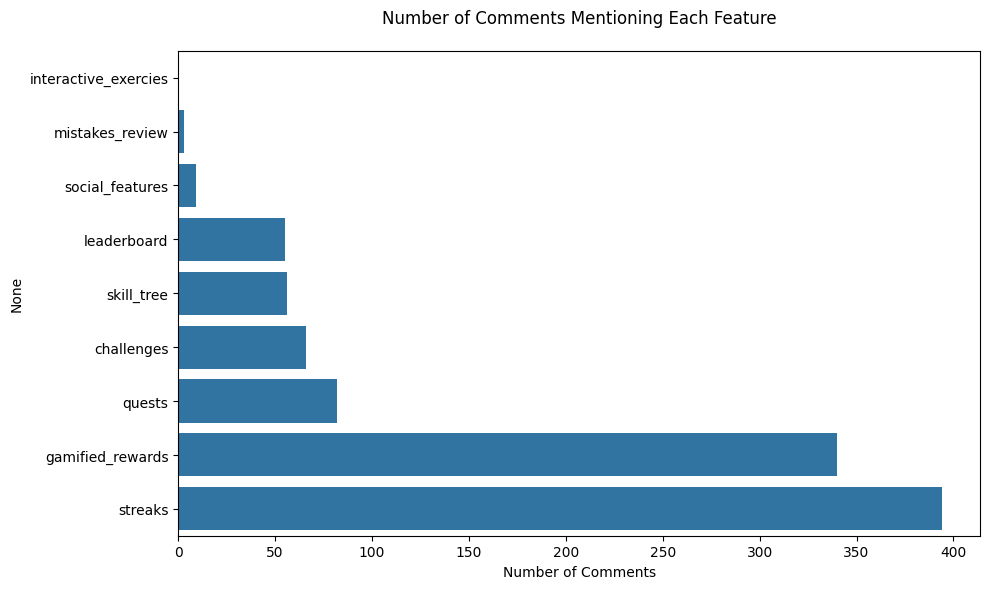

interactive_exercies      0
mistakes_review           3
social_features           9
leaderboard              55
skill_tree               56
challenges               66
quests                   82
gamified_rewards        340
streaks                 394
dtype: int64

In [37]:
# Initialize columns for each feature
for feature in feature_dict:
    df[feature] = 0
    
def is_relative_to_feature(comment: str, keywords_sets: list[list[str]]):
    if not isinstance(comment, str):
        return False
    for keywords in keywords_sets:
        if all(word in comment.split() for word in keywords):
            return True
    return False


for feature, keywords in feature_dict.items():
    # Convert to lowercase and check for each keyword
    df[feature] = df['comment_text'].str.lower().apply(lambda x: is_relative_to_feature(x, keywords))

# Get total counts for each feature
feature_counts = df[list(feature_dict.keys())].sum().sort_values(ascending=True)

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_counts.values, y=feature_counts.index)
plt.title('Number of Comments Mentioning Each Feature', pad=20)
plt.xlabel('Number of Comments')
plt.tight_layout()
plt.show()
feature_counts

In [39]:
# Get top 10 comments for each feature and save to CSV
import os

# Create results directory if it doesn't exist
os.makedirs('results', exist_ok=True)

for feature in feature_dict.keys():
    # Filter comments that mention the feature and get the top 10 with highest scores
    top_comments = df[df[feature] == 1].nlargest(min(100, len(df[df[feature] == 1])), 'score')
    
    if not top_comments.empty:
        # Print the top comment for reference
        print(f"\n{'='*100}")
        print(f"Top comment for {feature} (score: {top_comments['score'].values[0]}):")
        print(f"{top_comments['comment_text'].values[0]}")
        
        # Save top 10 comments to CSV
        csv_path = f'results/top_{feature}_{dataset_name}.csv'
        top_comments.to_csv(csv_path, index=False)
        print(f"Saved top 10 comments for {feature} to {csv_path}")



Top comment for streaks (score: 877):
I actually love these because I have a friend streak with my dad and the messages are nothing like he would ever write so it’s hilarious to me when they come through 😂
Saved top 10 comments for streaks to results/top_streaks_dataset_20250222_163044.csv

Top comment for leaderboard (score: 892):
I don't think it is a cover-up. As u/murray_paul pointed out, those of us on the subreddit represent only a tiny fraction of users. **Many  other users are just happily doing their lessons unaware that customer service is a big issue.** 

I had jury duty earlier this week. One of the people sitting near me has been taking the French course on Duo. She wants to do Italian next so I showed her how to add the course. I also gave her the link to Wiktionary so she can look up words. She is perfectly content.

My mom e-mails me screenshots of her league standings one or more times per week. She says she won't make top 3 this week and is expecting to be fifth or s

In [6]:
feature = 'skill_tree'
filtered = df[df[feature] == 1]
for x in filtered['comment_text'].sample(min(10, len(filtered))):
    print(x)
    full_list = list(set([word for sublist in feature_dict[feature] for word in sublist]))
    print(f'wrods: {[word for word in full_list if word in x]}')
    print('-'*100)

Sorry, for clarification, when you say a couple of units in an hour, do you mean one of the circles in the path that has 3 to 6 lessons in each? Or do you mean the entire unit which has about 12 of these stones?
wrods: ['path']
----------------------------------------------------------------------------------------------------
Right. The issue I’m having is both are technically correct (I think) but my app is so broken that I can’t identify what went wrong? I can’t even continue the french path my app is so broken.
wrods: ['path']
----------------------------------------------------------------------------------------------------
I guess I was hoping for a way to just do it without the path steps
wrods: ['path']
----------------------------------------------------------------------------------------------------
Mobile only here. I get gems from doing path (5-15 after completing some of the levels, I don't keep track which) and keeping my streak (Duo asks me to set a "streak goal" and I

## Languages markup

In [7]:
from pycountry import languages
from collections import Counter

# Get all words from comments
all_words = ' '.join(text.lower() for text in df['comment_text'] if isinstance(text, str)).split()

# Count occurrences of each language
language_counts = Counter()
for lang in languages:
    lang_name = lang.name.lower()
    if lang_name in all_words:
        count = all_words.count(lang_name)
        language_counts[lang_name] = count

# Sort languages by count in descending order
sorted_languages = sorted(language_counts.items(), key=lambda x: x[1], reverse=True)

print(f'Number of languages found: {len(sorted_languages)}')
print('\nTop languages by mentions:')
for lang, count in sorted_languages:
    print(f'{lang}: {count}')

Number of languages found: 167

Top languages by mentions:
to: 8310
are: 2005
as: 1541
even: 594
german: 459
day: 416
english: 416
spanish: 398
french: 346
she: 316
japanese: 231
bit: 170
russian: 158
u: 121
chinese: 104
italian: 88
korean: 88
zari: 80
dutch: 72
norwegian: 61
en: 54
polish: 48
tho: 48
latin: 47
swedish: 47
e: 38
portuguese: 34
hebrew: 27
romanian: 27
busuu: 26
thai: 24
danish: 22
gen: 22
ha: 22
tu: 22
indonesian: 21
finnish: 20
ukrainian: 19
welsh: 18
irish: 18
mayo: 18
czech: 17
con: 15
sie: 15
navajo: 15
turkish: 15
arabic: 14
ik: 14
una: 12
vietnamese: 12
esperanto: 11
gun: 11
hehe: 11
persian: 10
pero: 10
hindi: 9
mon: 9
au: 8
dem: 8
na: 8
aka: 8
ding: 7
haitian: 7
hungarian: 7
logo: 7
che: 7
wa: 7
afrikaans: 6
hawaiian: 6
hu: 6
dari: 6
som: 6
tagalog: 6
klingon: 6
yiddish: 6
kein: 5
fam: 5
icelandic: 5
mum: 5
pam: 5
sake: 5
shi: 5
tal: 5
tiene: 5
lame: 4
estonian: 4
gebe: 4
geez: 4
pinyin: 4
slovak: 4
soo: 4
dan: 3
dong: 3
filipino: 3
han: 3
noon: 3
uni: 3
zulu: 3

In [8]:
allowed_languages = [  # manually selected from previous output
"german",
"english",
"spanish",
"french", 
"japanese",
"russian",
"chinese",
"italian",
"korean", 
"zari",
"dutch",
"norwegian",
"polish",
"latin",
"swedish",
"portuguese",
"hebrew",
"romanian", 
"busuu",
"thai",
"danish",
"indonesian",
"finnish",
"ukrainian",
"welsh",
"irish",
"mayo",
"czech",
"con",
"sie",
"navajo",
"turkish",
"arabic",
"vietnamese",
"esperanto",
"persian",
"pero",
"hindi",
"haitian",
"hungarian",
"afrikaans",
"hawaiian",
"dari",
"tagalog",
"klingon",
"yiddish",
"kein",
"icelandic",
"estonian",
"gebe",
"geez",
"pinyin",
"slovak",
"filipino",
"zulu",
"sari",
]

In [9]:
# Create language columns initialized to False
for lang in allowed_languages:
    df[f'lang_{lang}'] = False
    
# Mark languages found in text
for lang in allowed_languages:
    # Case insensitive search for language name in text
    df[f'lang_{lang}'] = df['comment_text'].str.lower().str.contains(r'\b' + lang.lower() + r'\b', regex=True)

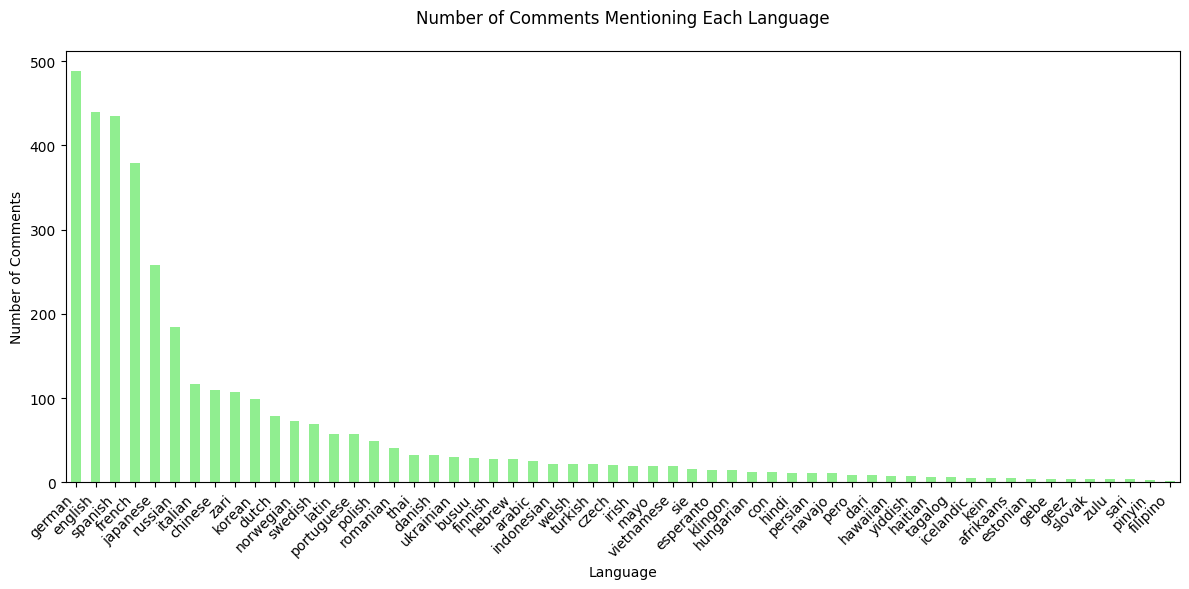


Number of comments mentioning each language:
german        488
english       440
spanish       435
french        379
japanese      258
russian       185
italian       117
chinese       110
zari          107
korean         99
dutch          79
norwegian      73
swedish        69
latin          57
portuguese     57
polish         49
romanian       41
thai           33
danish         33
ukrainian      30
busuu          29
finnish        28
hebrew         28
arabic         26
indonesian     22
welsh          22
turkish        22
czech          21
irish          20
mayo           19
vietnamese     19
sie            16
esperanto      15
klingon        15
hungarian      13
con            12
hindi          11
persian        11
navajo         11
pero            9
dari            9
hawaiian        8
yiddish         8
haitian         6
tagalog         6
icelandic       5
kein            5
afrikaans       5
estonian        4
gebe            4
geez            4
slovak          4
zulu            4


In [10]:
# Count comments mentioning each language
language_counts = pd.Series({
    lang: df[f'lang_{lang}'].sum() 
    for lang in allowed_languages
}).sort_values(ascending=False)

# Create bar plot
plt.figure(figsize=(12, 6))
language_counts.plot(kind='bar', color='lightgreen')
plt.title('Number of Comments Mentioning Each Language', pad=20)
plt.xlabel('Language')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print the counts
print("\nNumber of comments mentioning each language:")
print(language_counts)


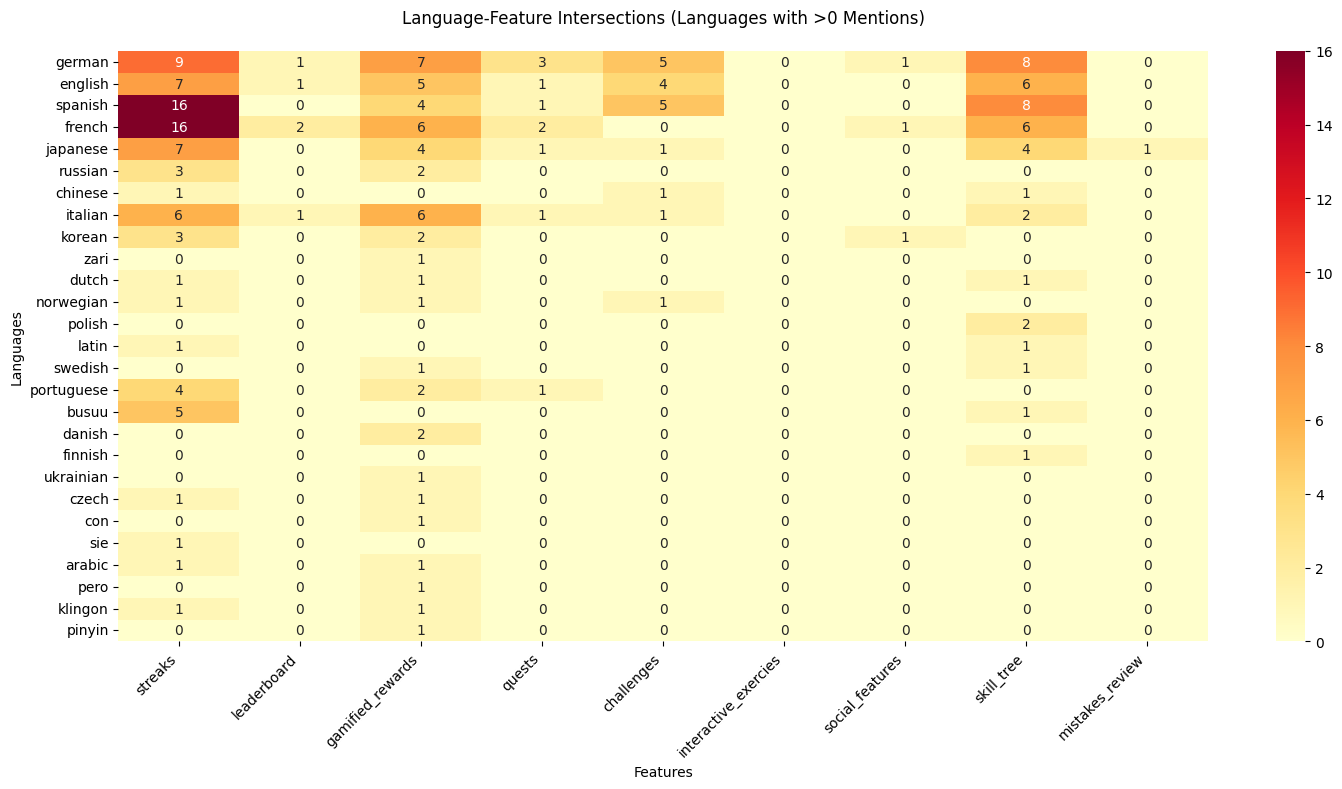


Intersection counts between languages and features:
            streaks  leaderboard  gamified_rewards  quests  challenges  \
german            9            1                 7       3           5   
english           7            1                 5       1           4   
spanish          16            0                 4       1           5   
french           16            2                 6       2           0   
japanese          7            0                 4       1           1   
russian           3            0                 2       0           0   
chinese           1            0                 0       0           1   
italian           6            1                 6       1           1   
korean            3            0                 2       0           0   
zari              0            0                 1       0           0   
dutch             1            0                 1       0           0   
norwegian         1            0                 1       0 

In [11]:
# Create a DataFrame to store feature-language intersections
intersection_data = []

# Calculate intersections for each language and feature
for lang in allowed_languages:
    lang_counts = {}
    lang_col = f'lang_{lang}'
    
    for feature in feature_dict.keys():
        # Count where both language and feature are True
        intersection_count = df[df[lang_col] & df[feature]].shape[0]
        lang_counts[feature] = intersection_count
        
    intersection_data.append(lang_counts)

# Create DataFrame from intersection counts    
intersection_df = pd.DataFrame(intersection_data, index=allowed_languages)

# Filter out languages with no feature intersections
intersection_df = intersection_df[intersection_df.sum(axis=1) > 0]

# Create heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(intersection_df, cmap='YlOrRd', annot=True, fmt='d')
plt.title('Language-Feature Intersections (Languages with >0 Mentions)', pad=20)
plt.xlabel('Features')
plt.ylabel('Languages')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print raw counts
print("\nIntersection counts between languages and features:")
print(intersection_df)


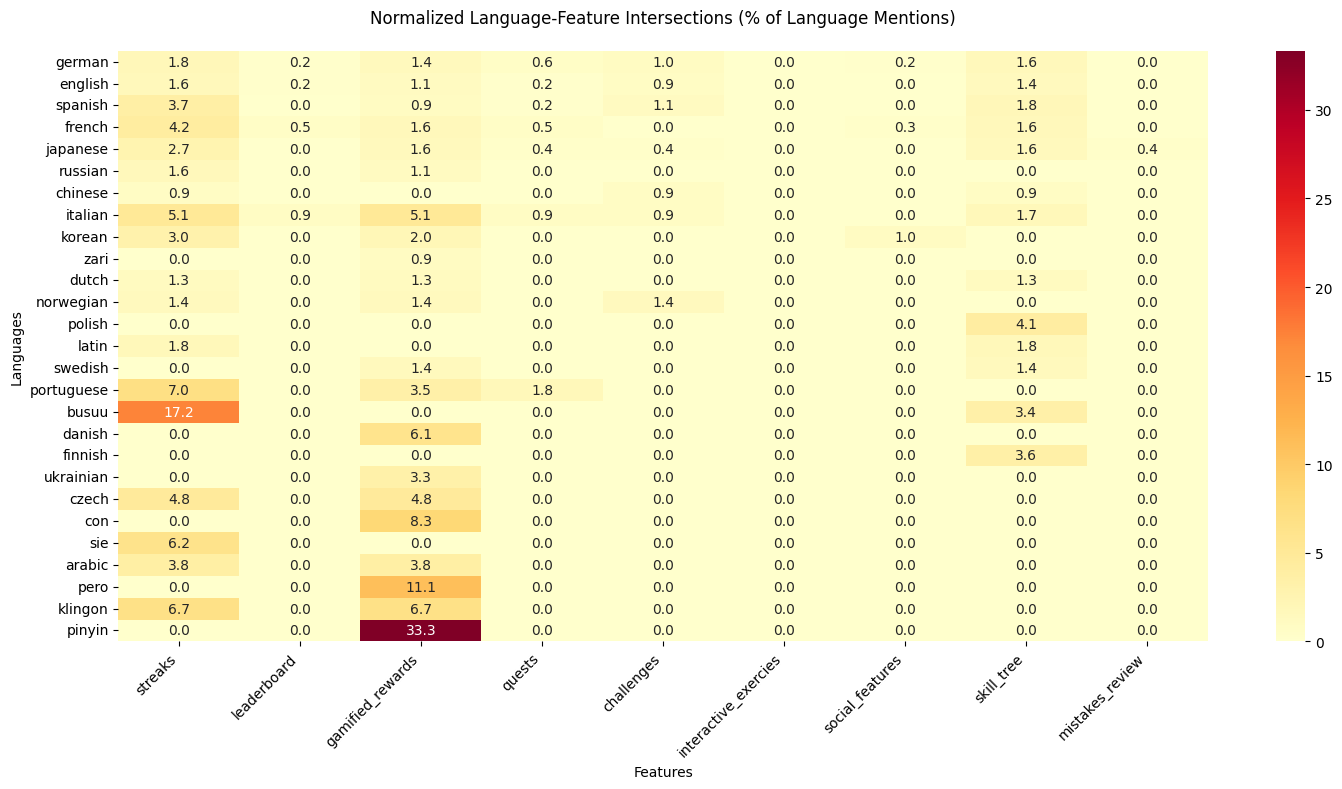


Normalized intersection percentages between languages and features:
              streaks  leaderboard  gamified_rewards    quests  challenges  \
german       1.844262     0.204918          1.434426  0.614754    1.024590   
english      1.590909     0.227273          1.136364  0.227273    0.909091   
spanish      3.678161     0.000000          0.919540  0.229885    1.149425   
french       4.221636     0.527704          1.583113  0.527704    0.000000   
japanese     2.713178     0.000000          1.550388  0.387597    0.387597   
russian      1.621622     0.000000          1.081081  0.000000    0.000000   
chinese      0.909091     0.000000          0.000000  0.000000    0.909091   
italian      5.128205     0.854701          5.128205  0.854701    0.854701   
korean       3.030303     0.000000          2.020202  0.000000    0.000000   
zari         0.000000     0.000000          0.934579  0.000000    0.000000   
dutch        1.265823     0.000000          1.265823  0.000000    0.00000

In [14]:
# Create a DataFrame to store feature-language intersections
intersection_data = []

# Calculate total occurrences of each language
language_totals = {}
for lang in allowed_languages:
    lang_col = f'lang_{lang}'
    language_totals[lang] = df[lang_col].sum()

# Calculate normalized intersections for each language and feature
for lang in allowed_languages:
    lang_counts = {}
    lang_col = f'lang_{lang}'
    total_lang_mentions = language_totals[lang]
    
    for feature in feature_dict.keys():
        # Count where both language and feature are True
        intersection_count = df[df[lang_col] & df[feature]].shape[0]
        # Normalize by total occurrences of the language
        if total_lang_mentions > 0:
            normalized_count = (intersection_count / total_lang_mentions) * 100
        else:
            normalized_count = 0
        lang_counts[feature] = normalized_count
        
    intersection_data.append(lang_counts)

# Create DataFrame from normalized intersection counts    
intersection_df = pd.DataFrame(intersection_data, index=allowed_languages)

# Filter out languages with no feature intersections
intersection_df = intersection_df[intersection_df.sum(axis=1) > 0]

# Create heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(intersection_df, cmap='YlOrRd', annot=True, fmt='.1f')
plt.title('Normalized Language-Feature Intersections (% of Language Mentions)', pad=20)
plt.xlabel('Features')
plt.ylabel('Languages')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print raw normalized counts
print("\nNormalized intersection percentages between languages and features:")
print(intersection_df)


In [15]:
# Show examples of comments mentioning Italian and gamified rewards
italian_gamified = df[df['lang_italian'] & df['gamified_rewards']]

print("\nExamples of comments mentioning both Italian and gamified rewards:")
print("-" * 80)
for idx, row in italian_gamified.iterrows():
    print(f"Comment (Score: {row['score']}):")
    print(row['comment_text'])
    print("-" * 80)



Examples of comments mentioning both Italian and gamified rewards:
--------------------------------------------------------------------------------
Comment (Score: 1):
Funny that altho the Italian level of duolingo is lower than German and I didn't finish it completely I can communicate much better and know all verb tenses and while in German I have 20K higher of XP I'm still stuck with articles and simply past and present
--------------------------------------------------------------------------------
Comment (Score: 23):
For real. As much as I want to hate on Duolingo for the choices they are making now, it's still a very useful tool **if you put effort into it**. A lot of people here expect that their desired language will just appear in their heads while they only do one or two lessons a day. "Hurrr I have a 1000 day streak and still can't have a conversation" and they got that streak by doing just a lesson per day. Or they want to just xp farm as much as possible, doing lessons a

## Basic Statistics

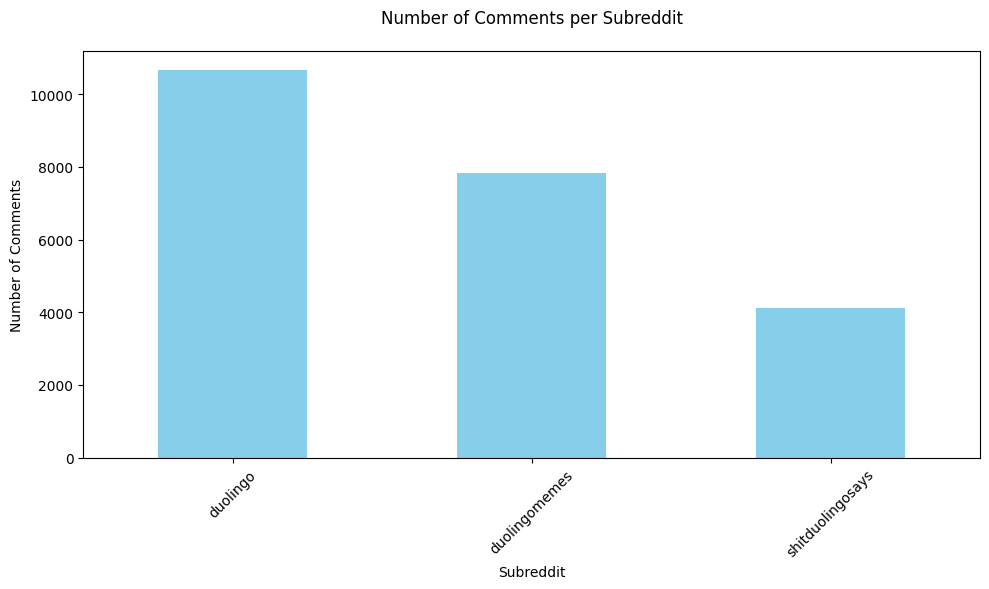


Comment Score Statistics by Subreddit:
                  count   mean  median   max
subreddit                                   
duolingo          10663  12.99     2.0  2942
duolingomemes      7837   3.83     2.0   371
shitduolingosays   4109   4.75     3.0   305


In [16]:
# Comments per subreddit
subreddit_counts = df['subreddit'].value_counts()

plt.figure()
subreddit_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Comments per Subreddit', pad=20)
plt.xlabel('Subreddit')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Comment score statistics
print("\nComment Score Statistics by Subreddit:")
stats_df = df.groupby('subreddit')['score'].agg(['count', 'mean', 'median', 'max']).round(2)
print(stats_df)

## Word Cloud Analysis

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/miagafarov/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


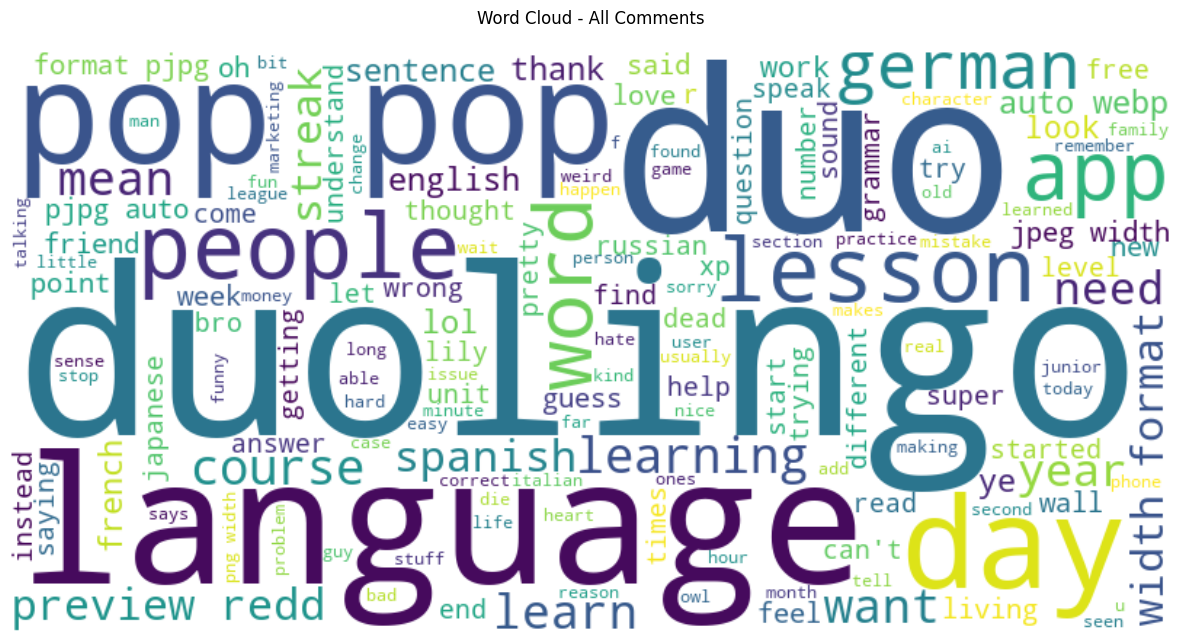

In [17]:
# Download required NLTK data
nltk.download('stopwords')

# Custom stop words including common Reddit terms
# Combine NLTK stopwords with spaCy's larger stopword list
from spacy.lang.en.stop_words import STOP_WORDS

custom_stopwords = set(stopwords.words('english')).union(STOP_WORDS).union([
    # Reddit/Internet specific
    'deleted', 'removed', 'http', 'https', 'www', 'com', 'amp', 'reddit', 'subreddit',
    'edit', 'post', 'comment', 'thread', 'karma', 'upvote', 'downvote',
    
    # Contractions
    'im', 'ive', 'id', 'ill', 'dont', 'doesnt', 'didnt', 'cant', 'couldnt', 
    'wouldnt', 'shouldnt', 'thats', 'theyre', 'youre', 'youll', 'wasnt', 'werent',
    'havent', 'hasnt', 'hadnt', 'wont', 'whats', 'theres', 'heres',
    
    # Common words that may not be in standard stopword lists
    'like', 'one', 'would', 'could', 'should', 'get', 'got', 'really', 'just',
    'way', 'make', 'made', 'thing', 'things', 'think', 'know', 'going', 'time',
    'even', 'actually', 'still', 'back', 'see', 'use', 'used', 'using', 'lot',
    'much', 'many', 'well', 'good', 'great', 'better', 'best', 'right', 'sure',
    'yeah', 'okay', 'ok', 'maybe', 'probably', 'definitely', 'basically',
    'literally', 'absolutely'
])

def generate_wordcloud(text, title):
    text = text.lower()
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        stopwords=custom_stopwords,
        min_font_size=10
    ).generate(text)
    
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, pad=20)
    plt.show()

# Generate word cloud for all comments
all_comments_text = ' '.join(df['comment_text'].dropna().astype(str))
generate_wordcloud(all_comments_text, 'Word Cloud - All Comments')


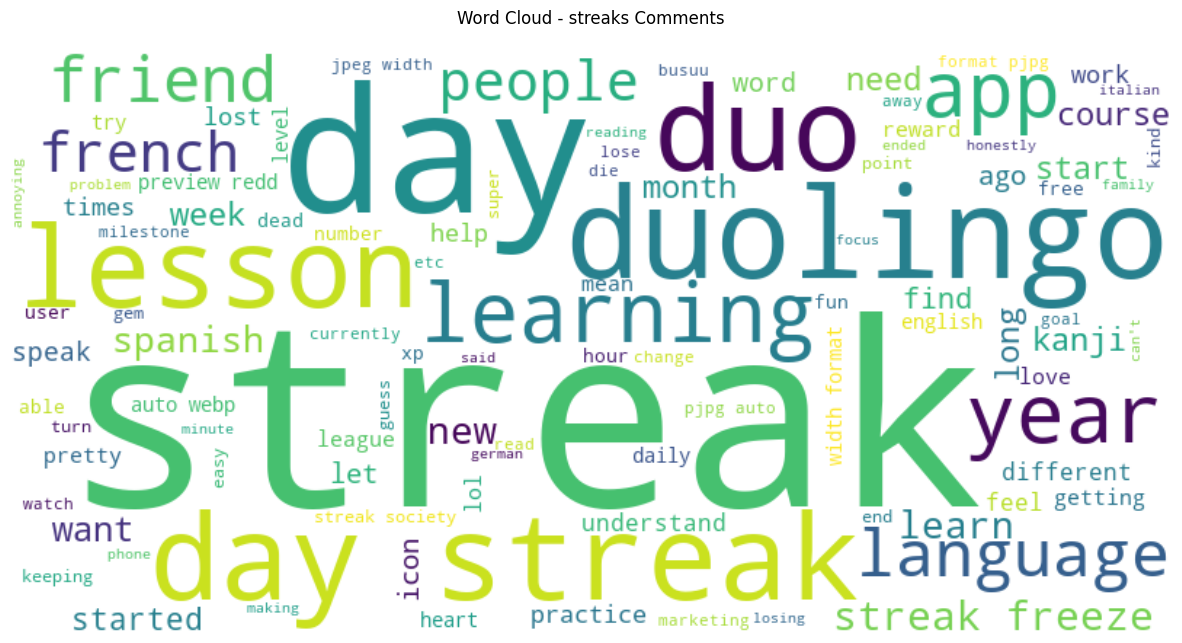

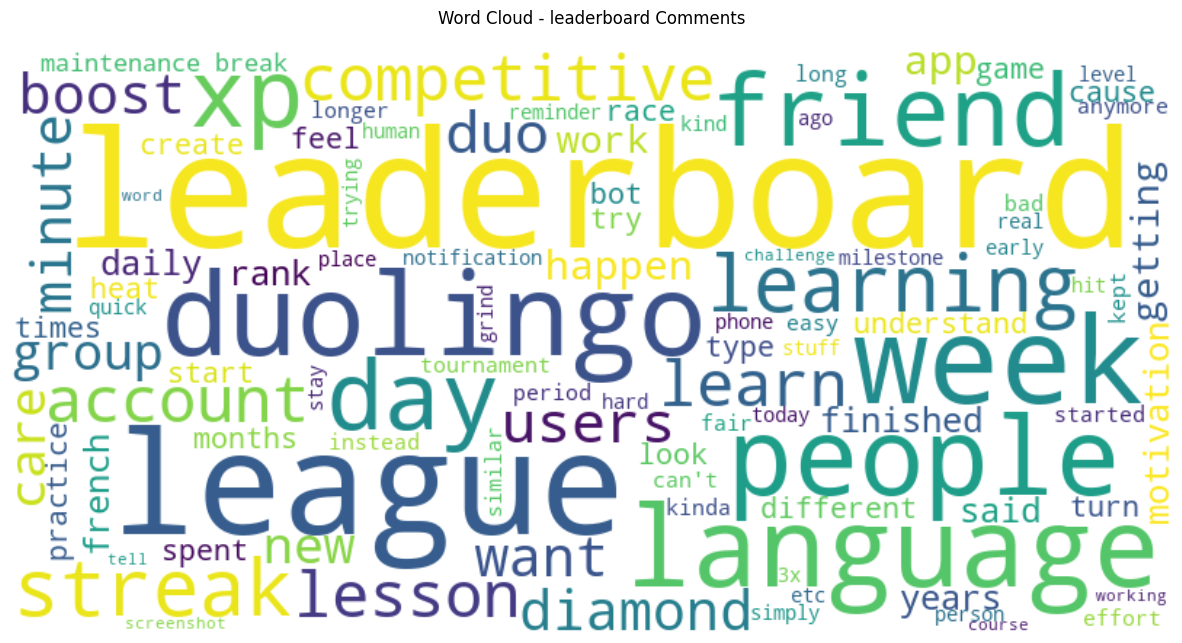

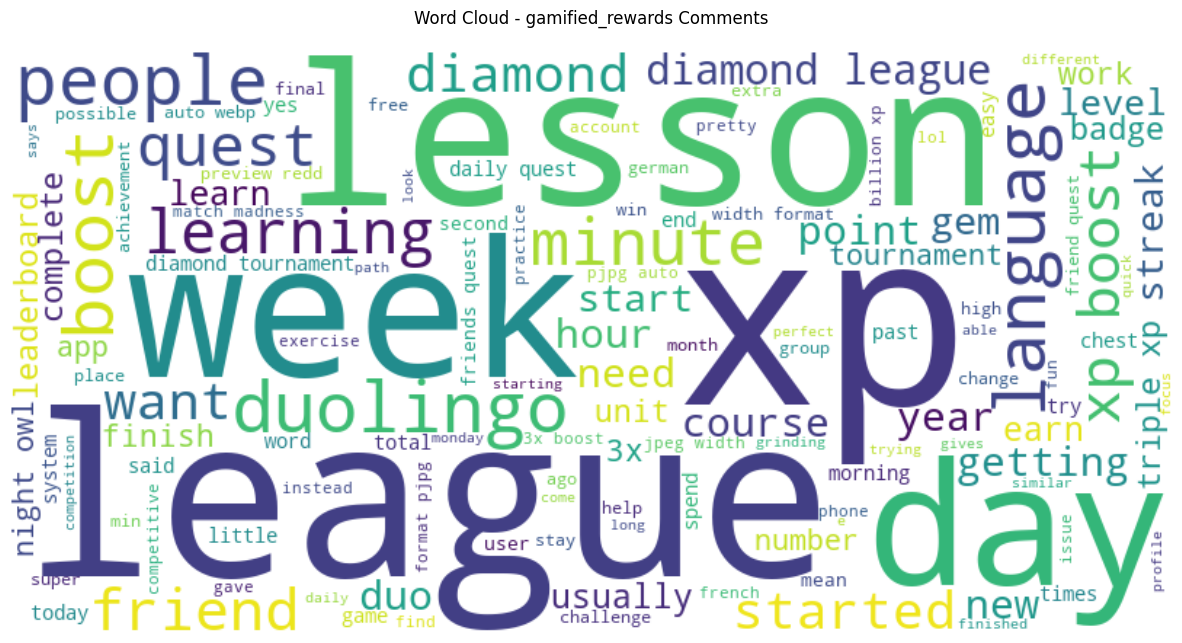

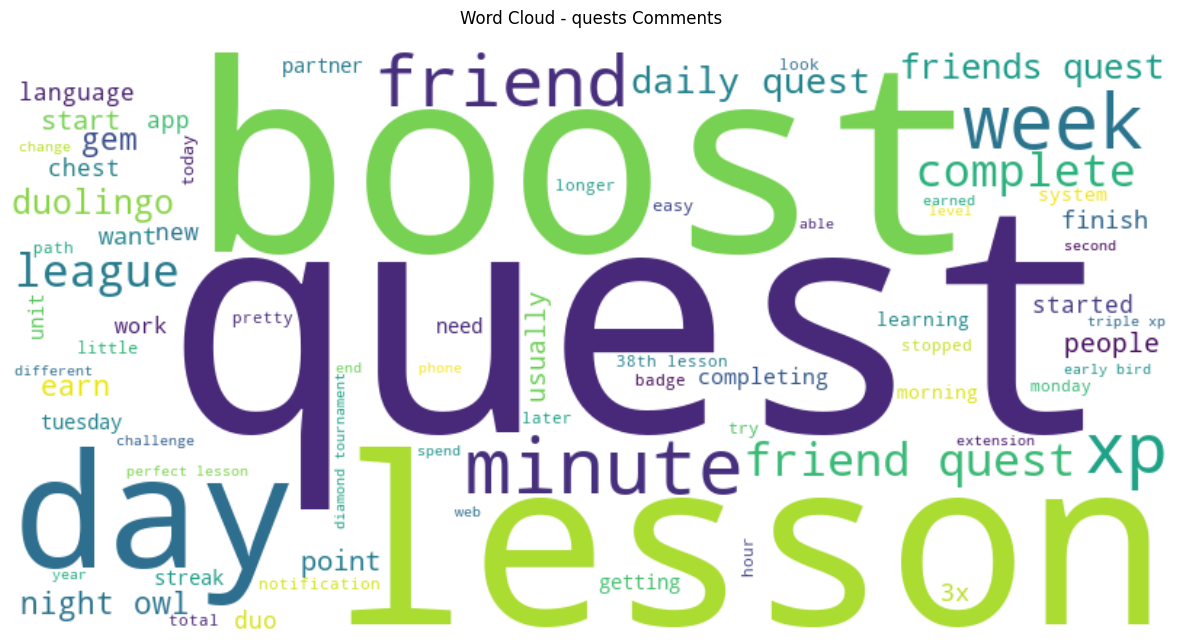

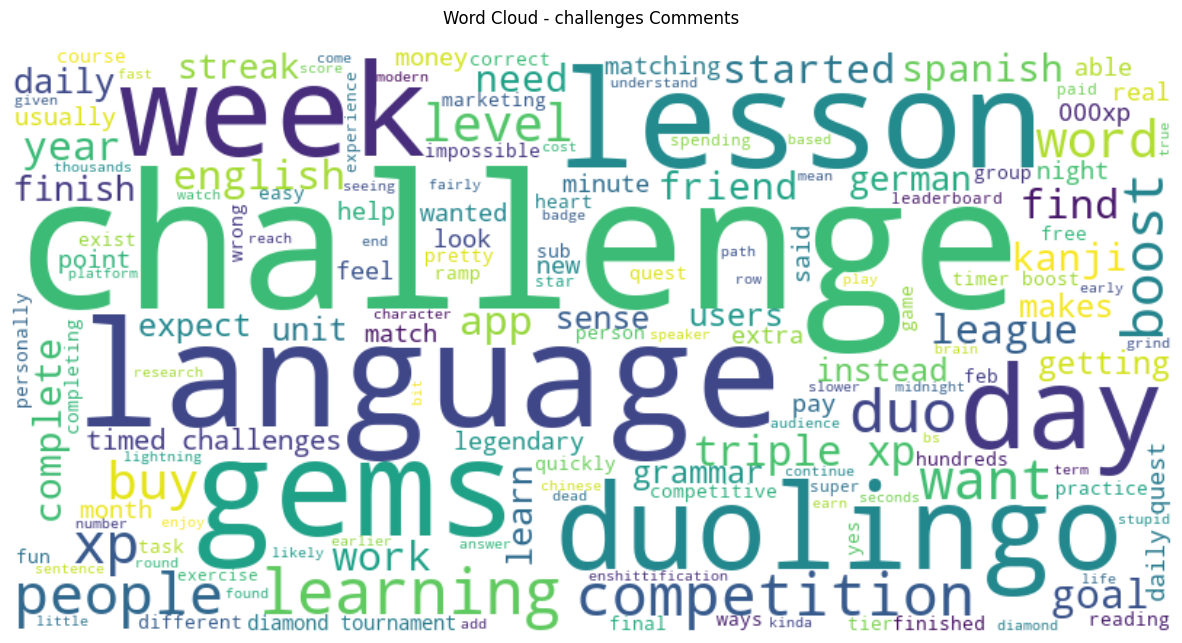

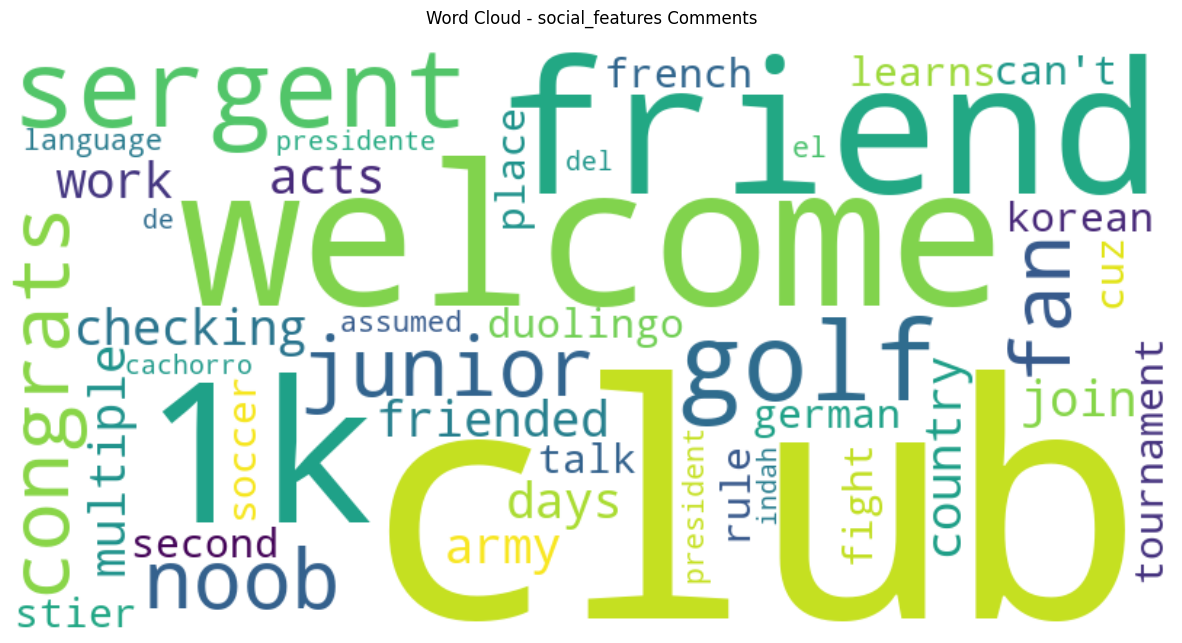

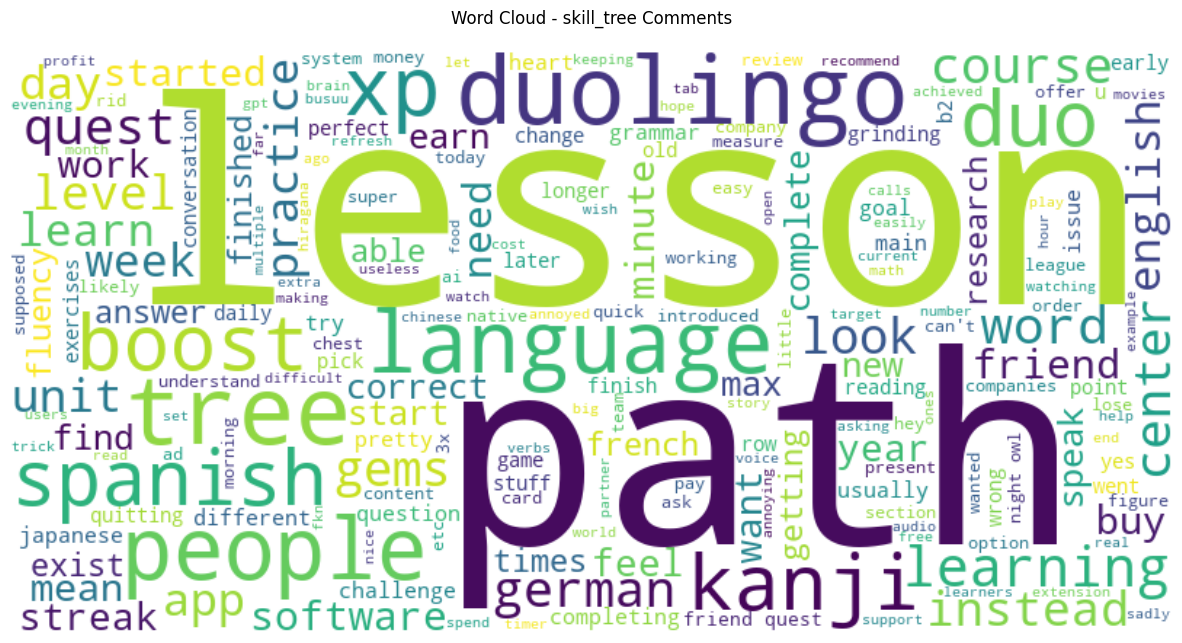

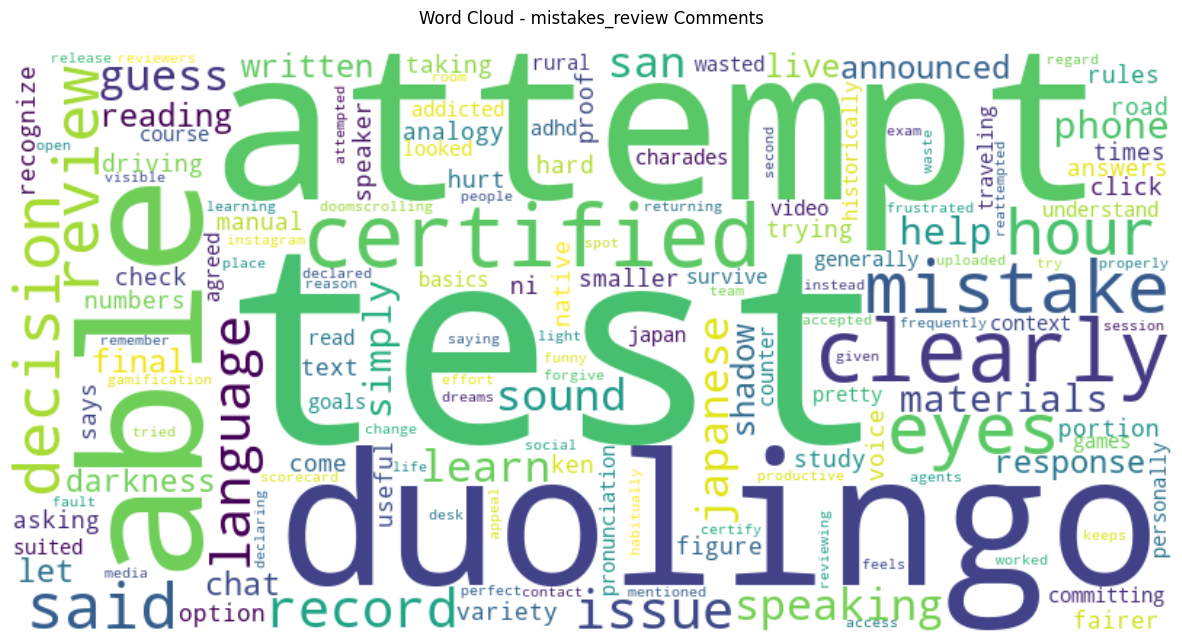

In [18]:

# Generate word cloud for each feature
for feature in feature_dict.keys():
    # Get comments that mention this feature
    feature_comments = df[df[feature] == 1]['comment_text']
    if len(feature_comments) > 0:
        # Combine all comments for this feature
        text = ' '.join(feature_comments.dropna().astype(str))
        generate_wordcloud(text, f'Word Cloud - {feature} Comments')

## Sentiment Analysis

In [19]:
def analyze_sentiment(df):
    # Calculate sentiment scores
    df['sentiment'] = df['comment_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

    # Categorize sentiments
    df['sentiment_category'] = pd.cut(df['sentiment'], 
                                    bins=[-1, -0.1, 0.1, 1], 
                                    labels=['Negative', 'Neutral', 'Positive'])

    # Count overall sentiments and ensure correct order
    sentiment_counts = df['sentiment_category'].value_counts()
    sentiment_counts = sentiment_counts.reindex(['Negative', 'Neutral', 'Positive'])
    
    return sentiment_counts

def plot_sentiment(sentiment_counts, title):
    # Create bar plot with custom colors
    plt.figure(figsize=(5, 3))
    ax = sentiment_counts.plot(kind='bar', width=0.8,
                             color=['red', 'gray', 'green'])
    plt.title(title, pad=20)
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Comments')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

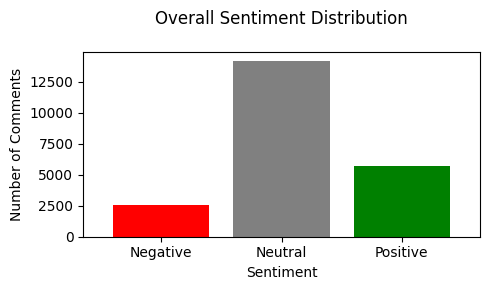

In [20]:
sentiment_counts = analyze_sentiment(df)
plot_sentiment(sentiment_counts, 'Overall Sentiment Distribution')

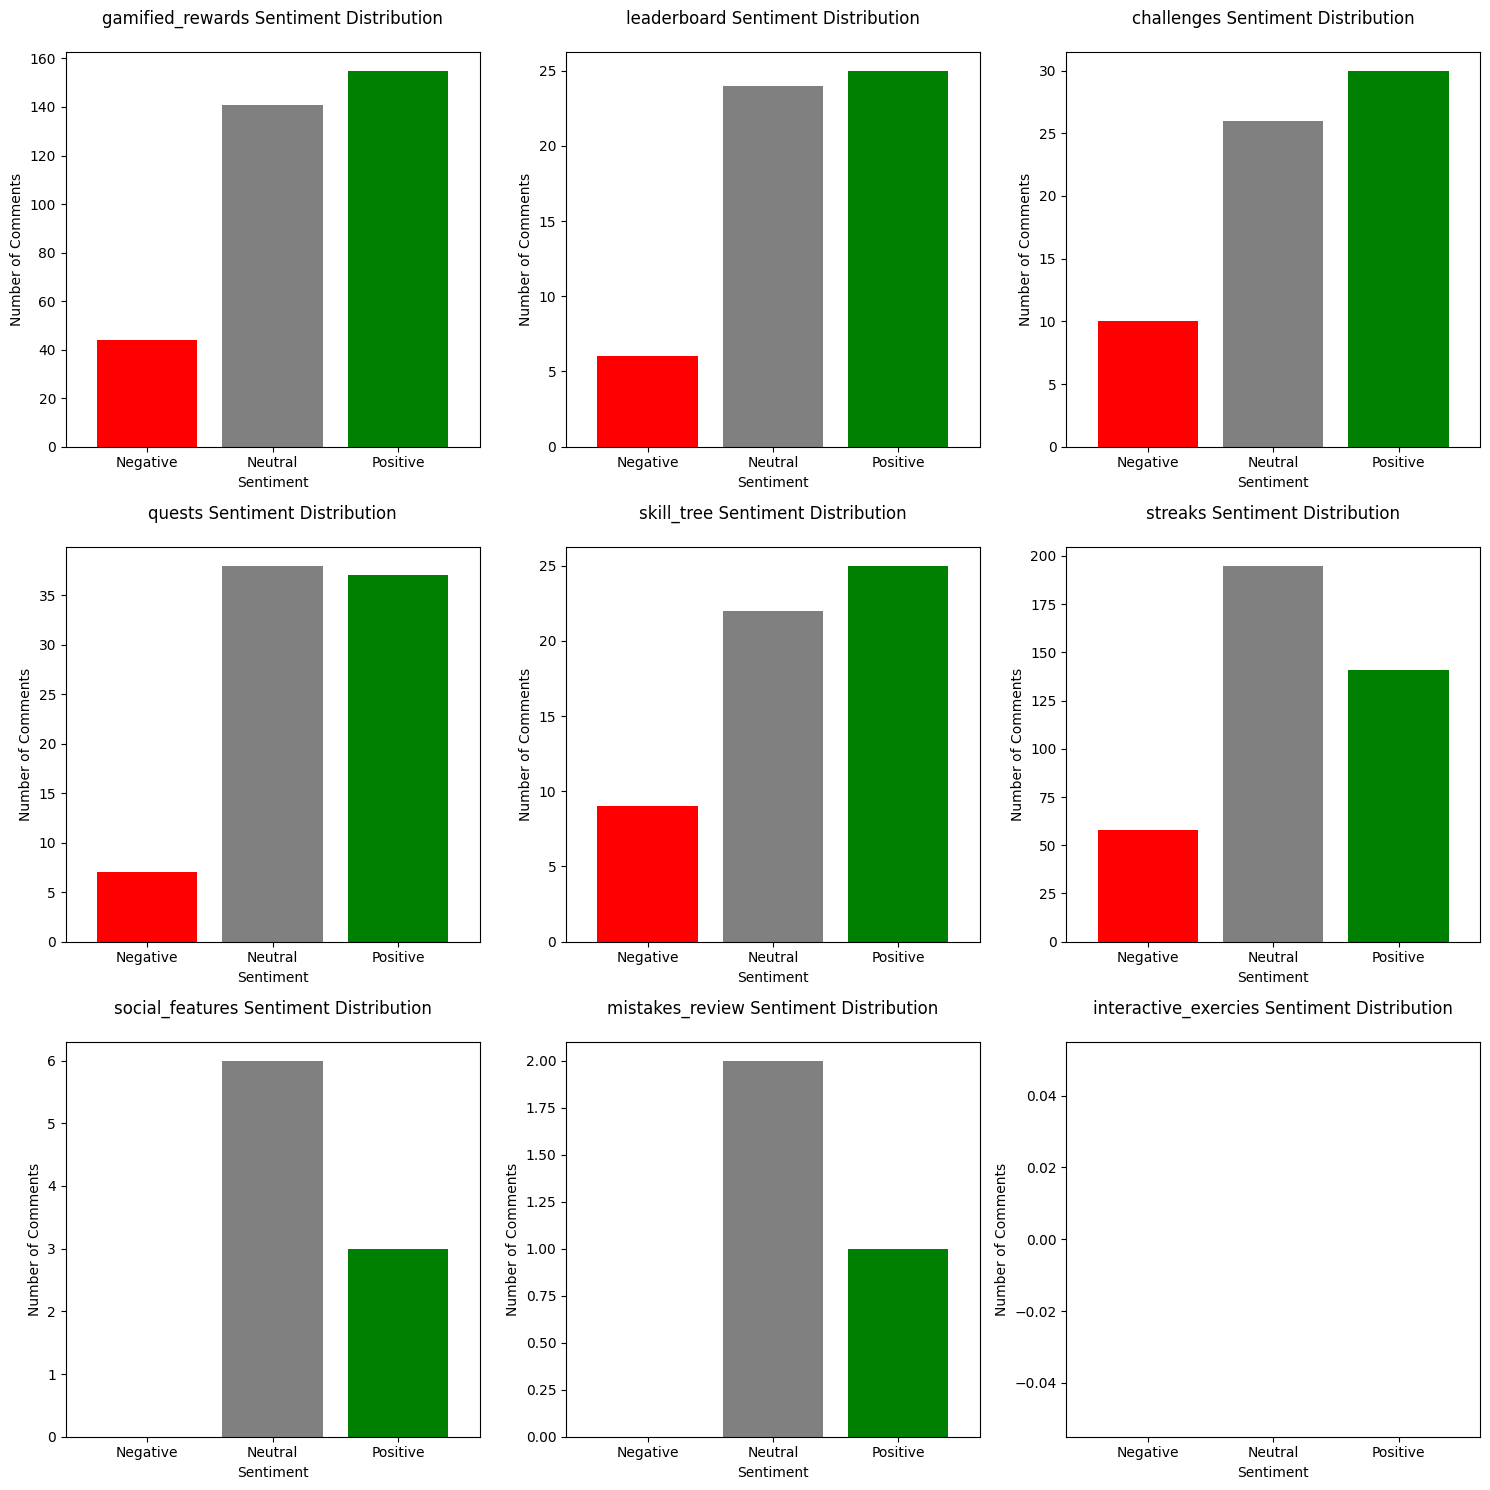

In [21]:
# Analyze sentiment for each feature and store results
feature_sentiments = {}
for feature in feature_dict:
    feature_df = df[df[feature] == 1].copy()
    sentiment_counts = analyze_sentiment(feature_df)
    # Calculate percentage of positive sentiment
    total = sentiment_counts.sum()
    pos_pct = (sentiment_counts['Positive'] / total) if total > 0 else 0
    feature_sentiments[feature] = (sentiment_counts, pos_pct)

# Sort features by positive sentiment percentage
sorted_features = sorted(feature_sentiments.items(), 
                        key=lambda x: x[1][1],
                        reverse=True)

# Plot sentiments in a grid
num_cols = 3  # Number of plots per row
num_features = len(sorted_features)
num_rows = (num_features + num_cols - 1) // num_cols

fig = plt.figure(figsize=(15, 5 * num_rows))
for idx, (feature, (sentiment_counts, _)) in enumerate(sorted_features):
    ax = plt.subplot(num_rows, num_cols, idx + 1)
    sentiment_counts.plot(kind='bar', width=0.8,
                         color=['red', 'gray', 'green'], ax=ax)
    plt.title(f'{feature} Sentiment Distribution', pad=20)
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Comments')
    plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

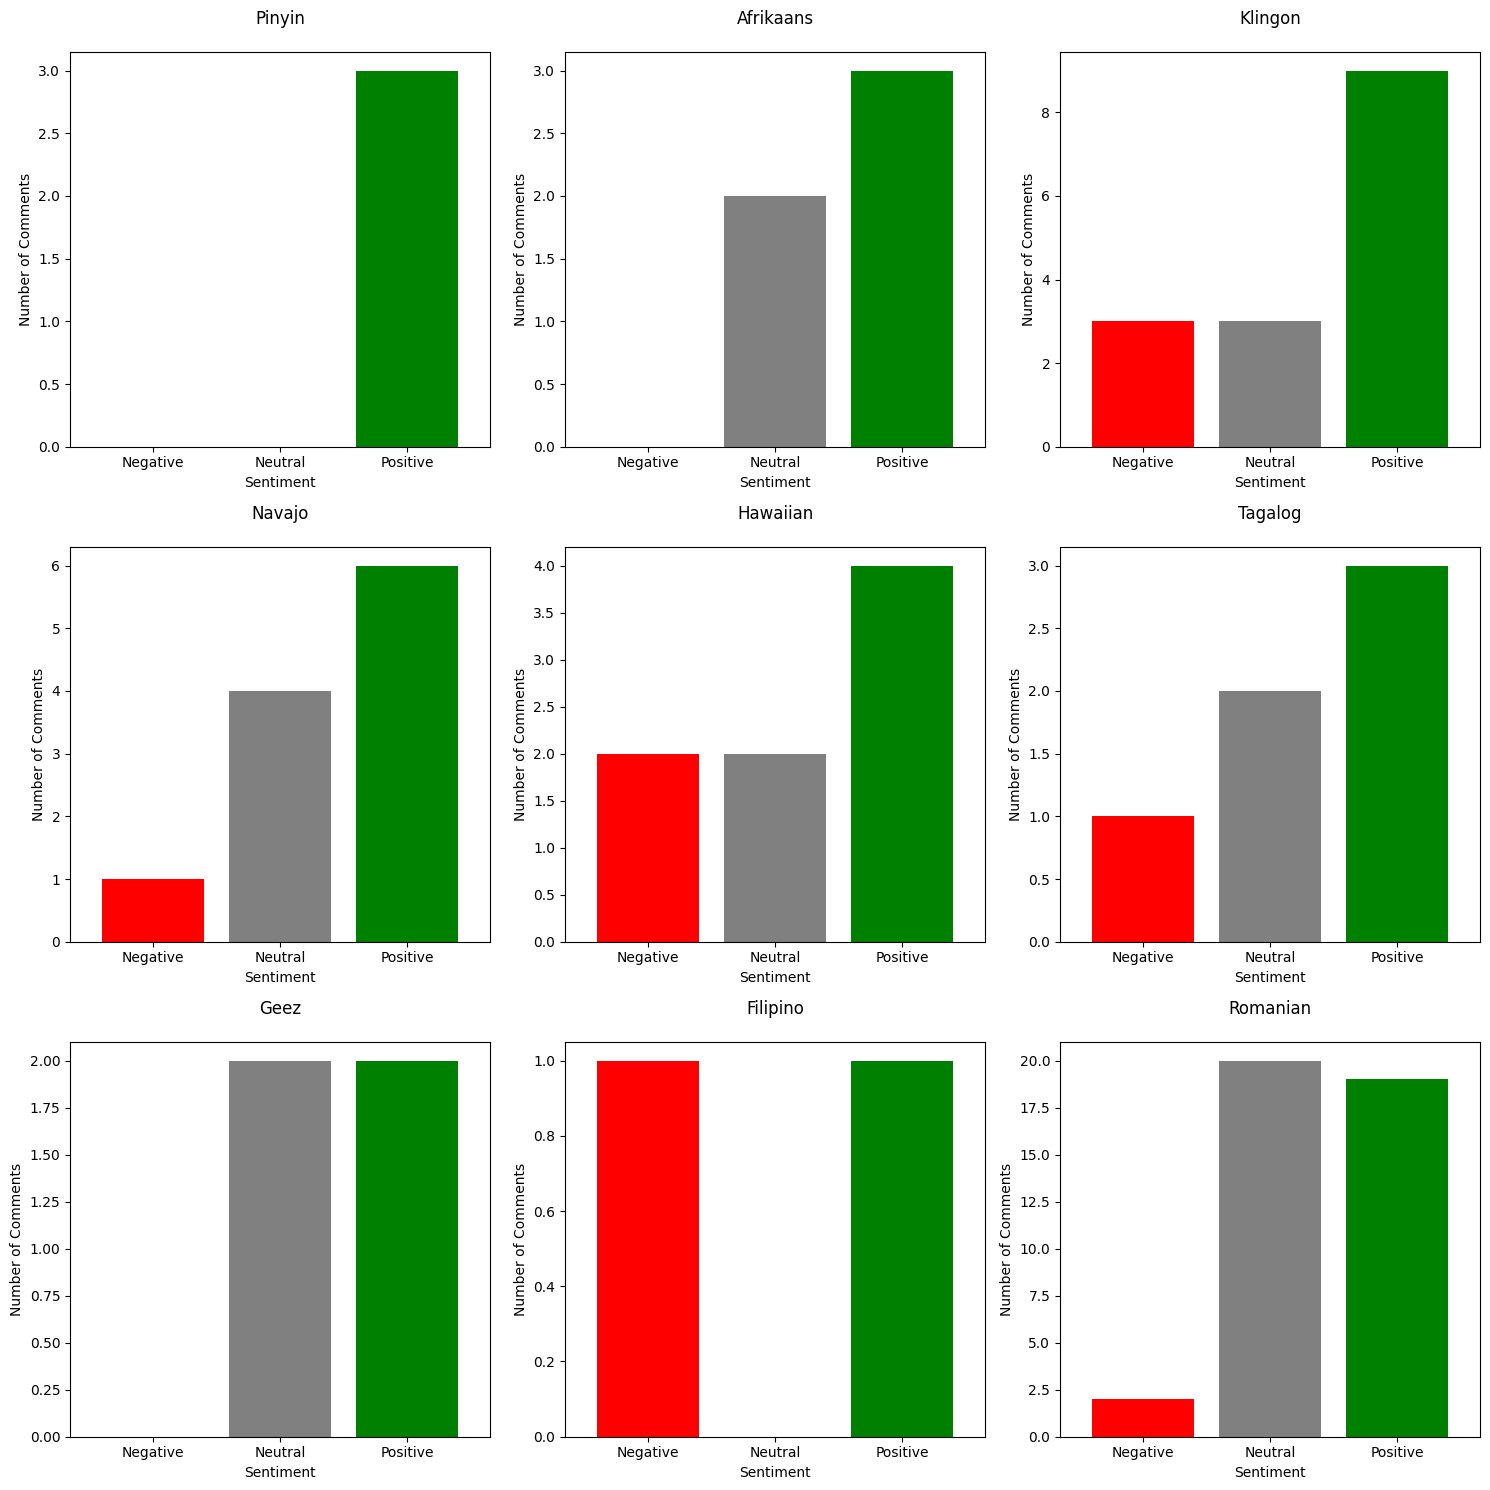

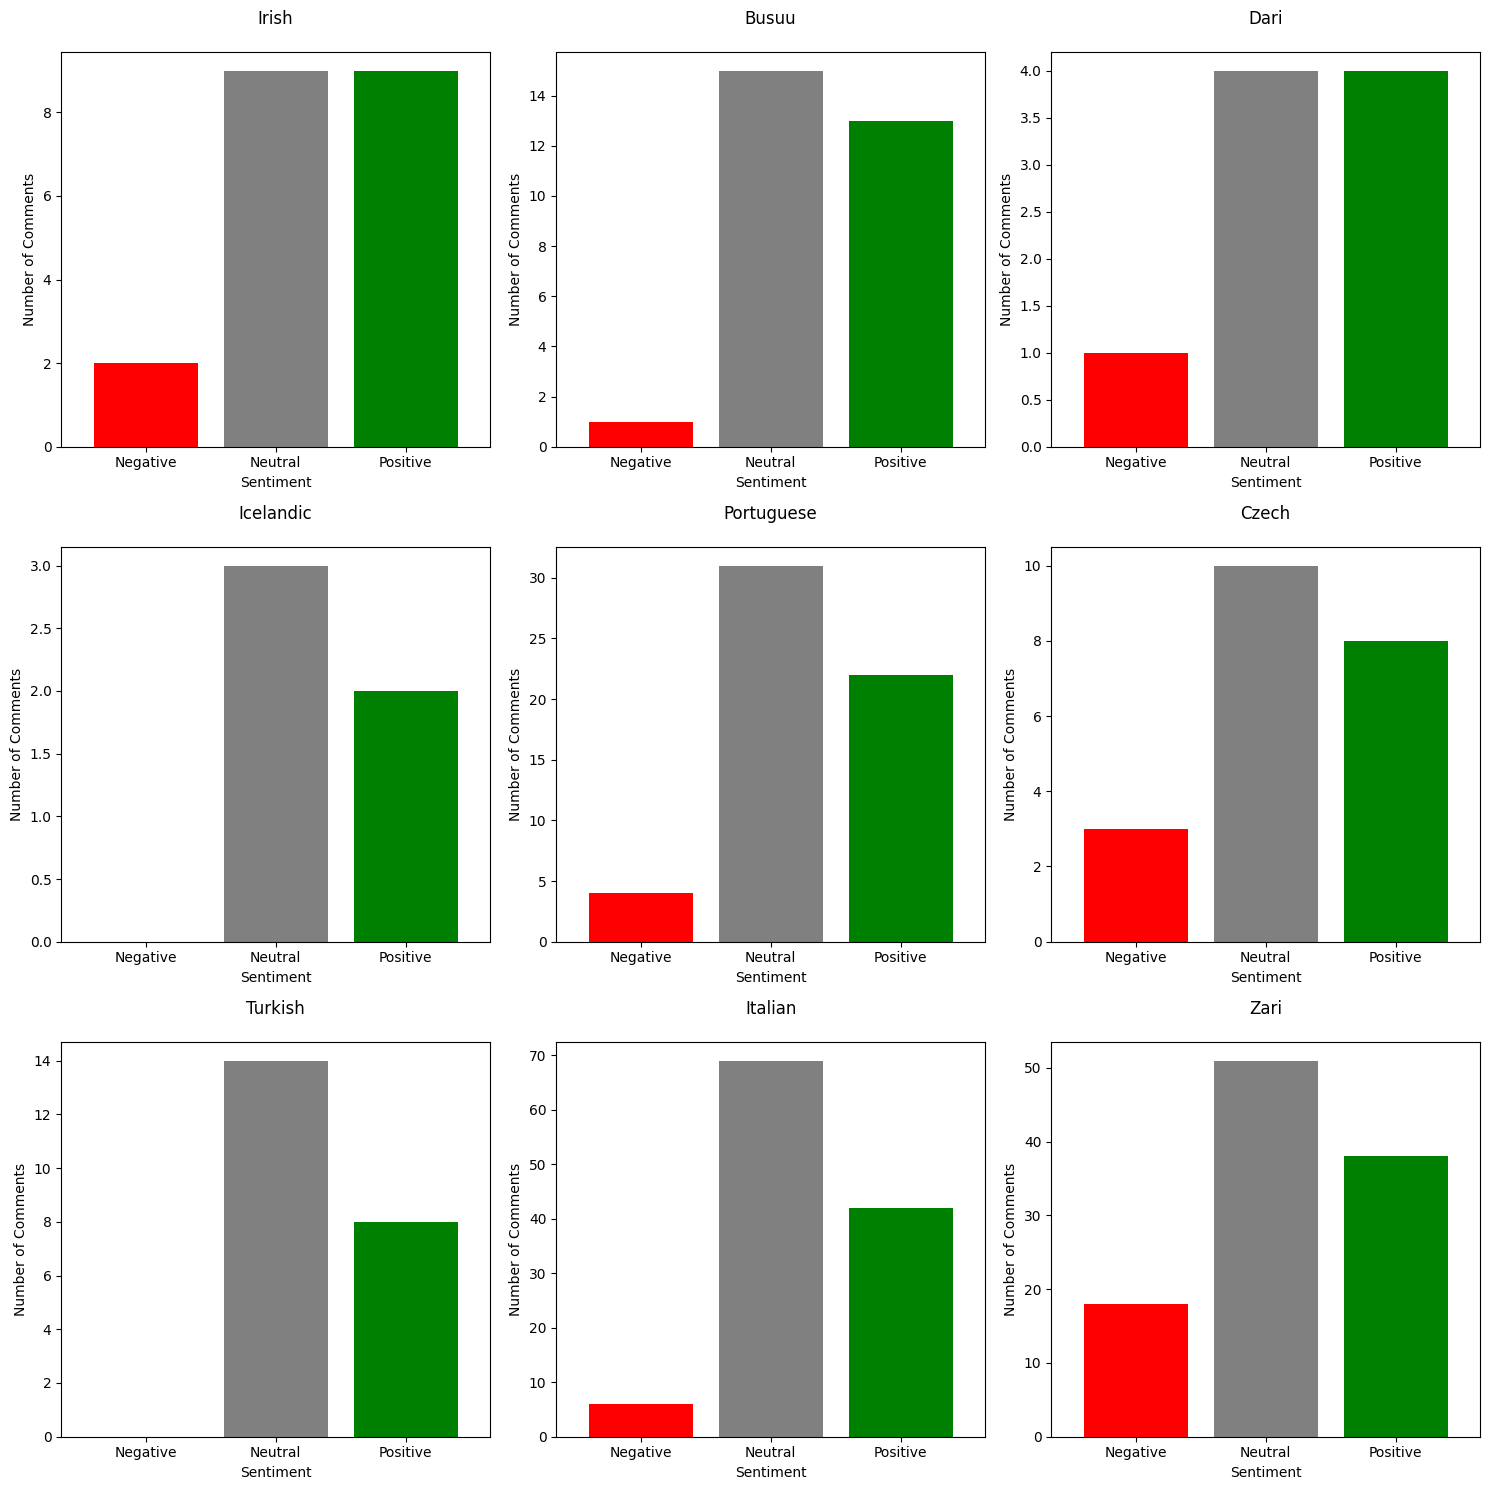

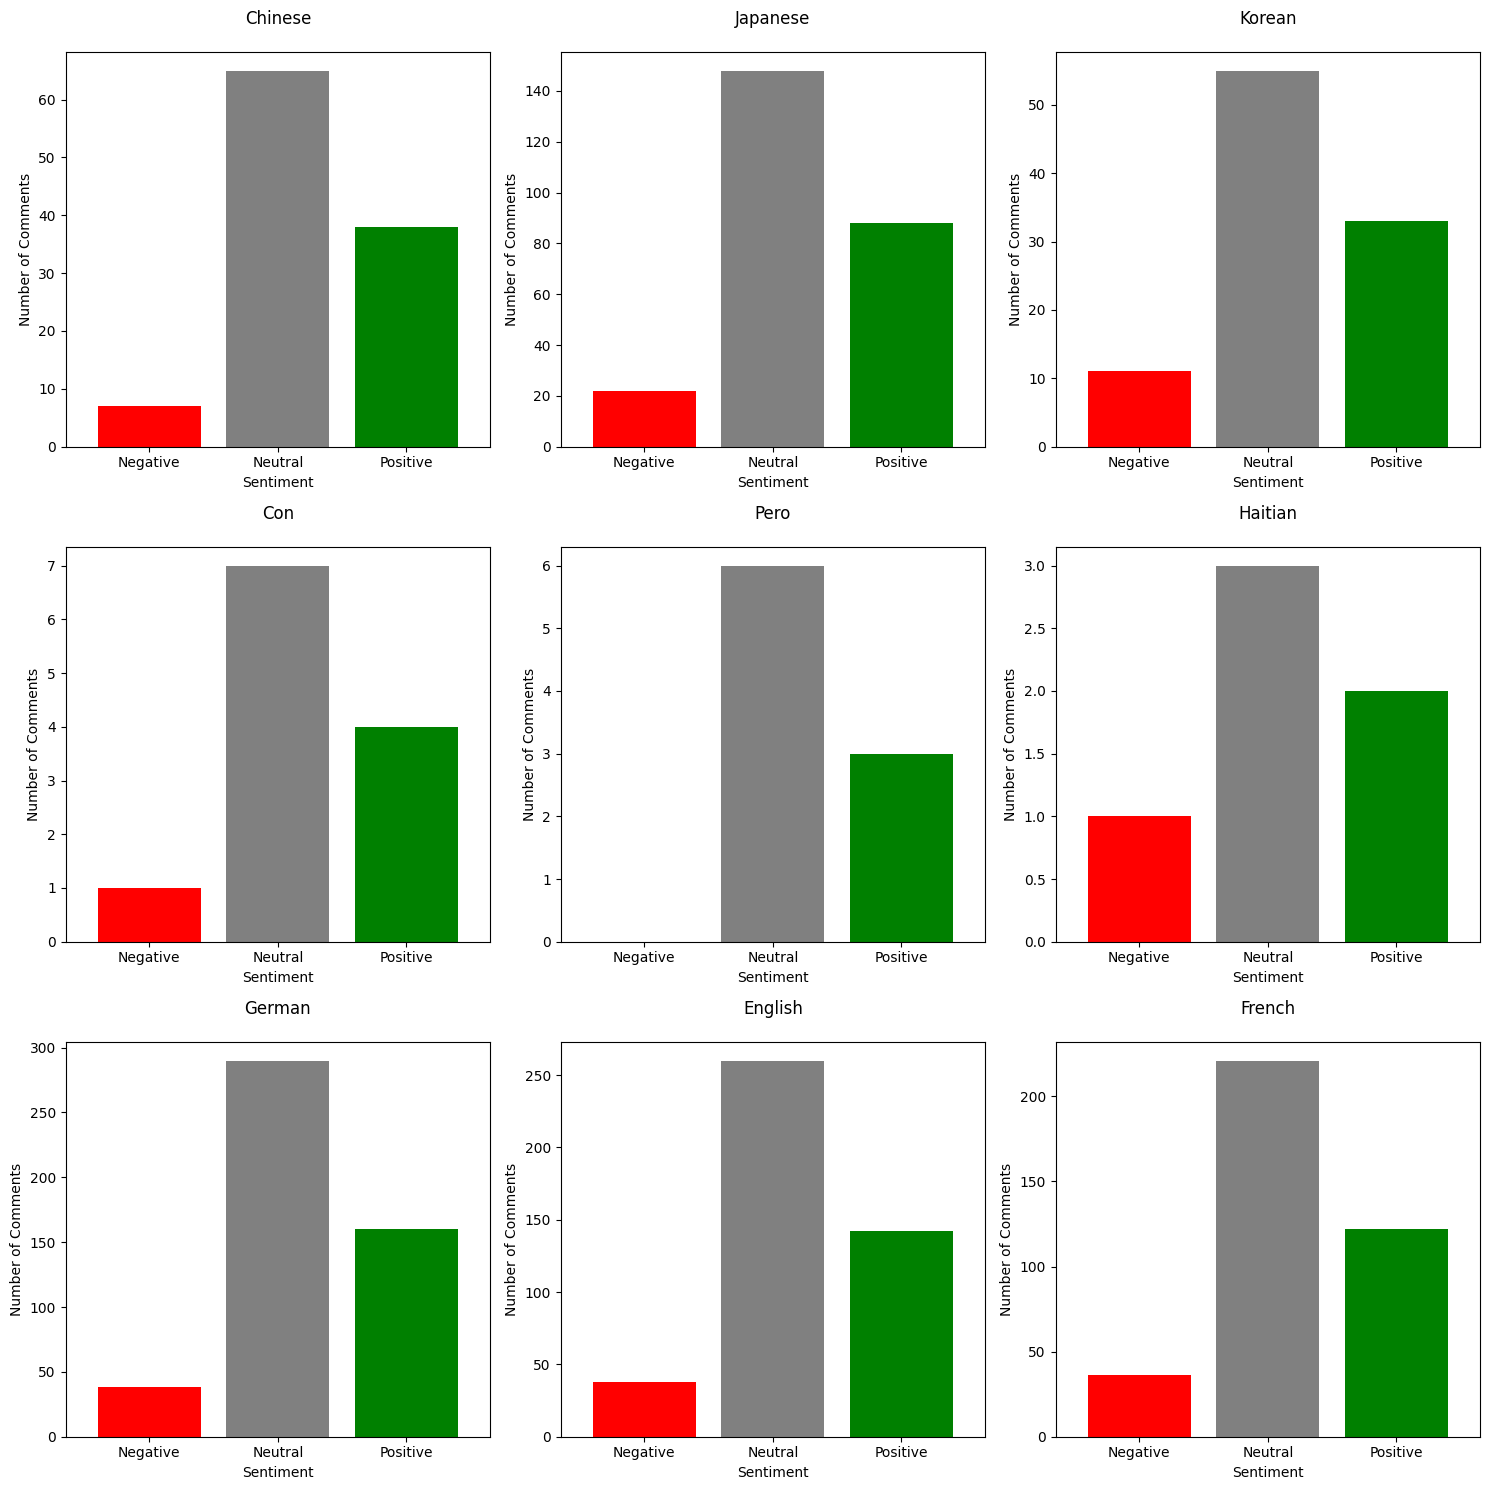

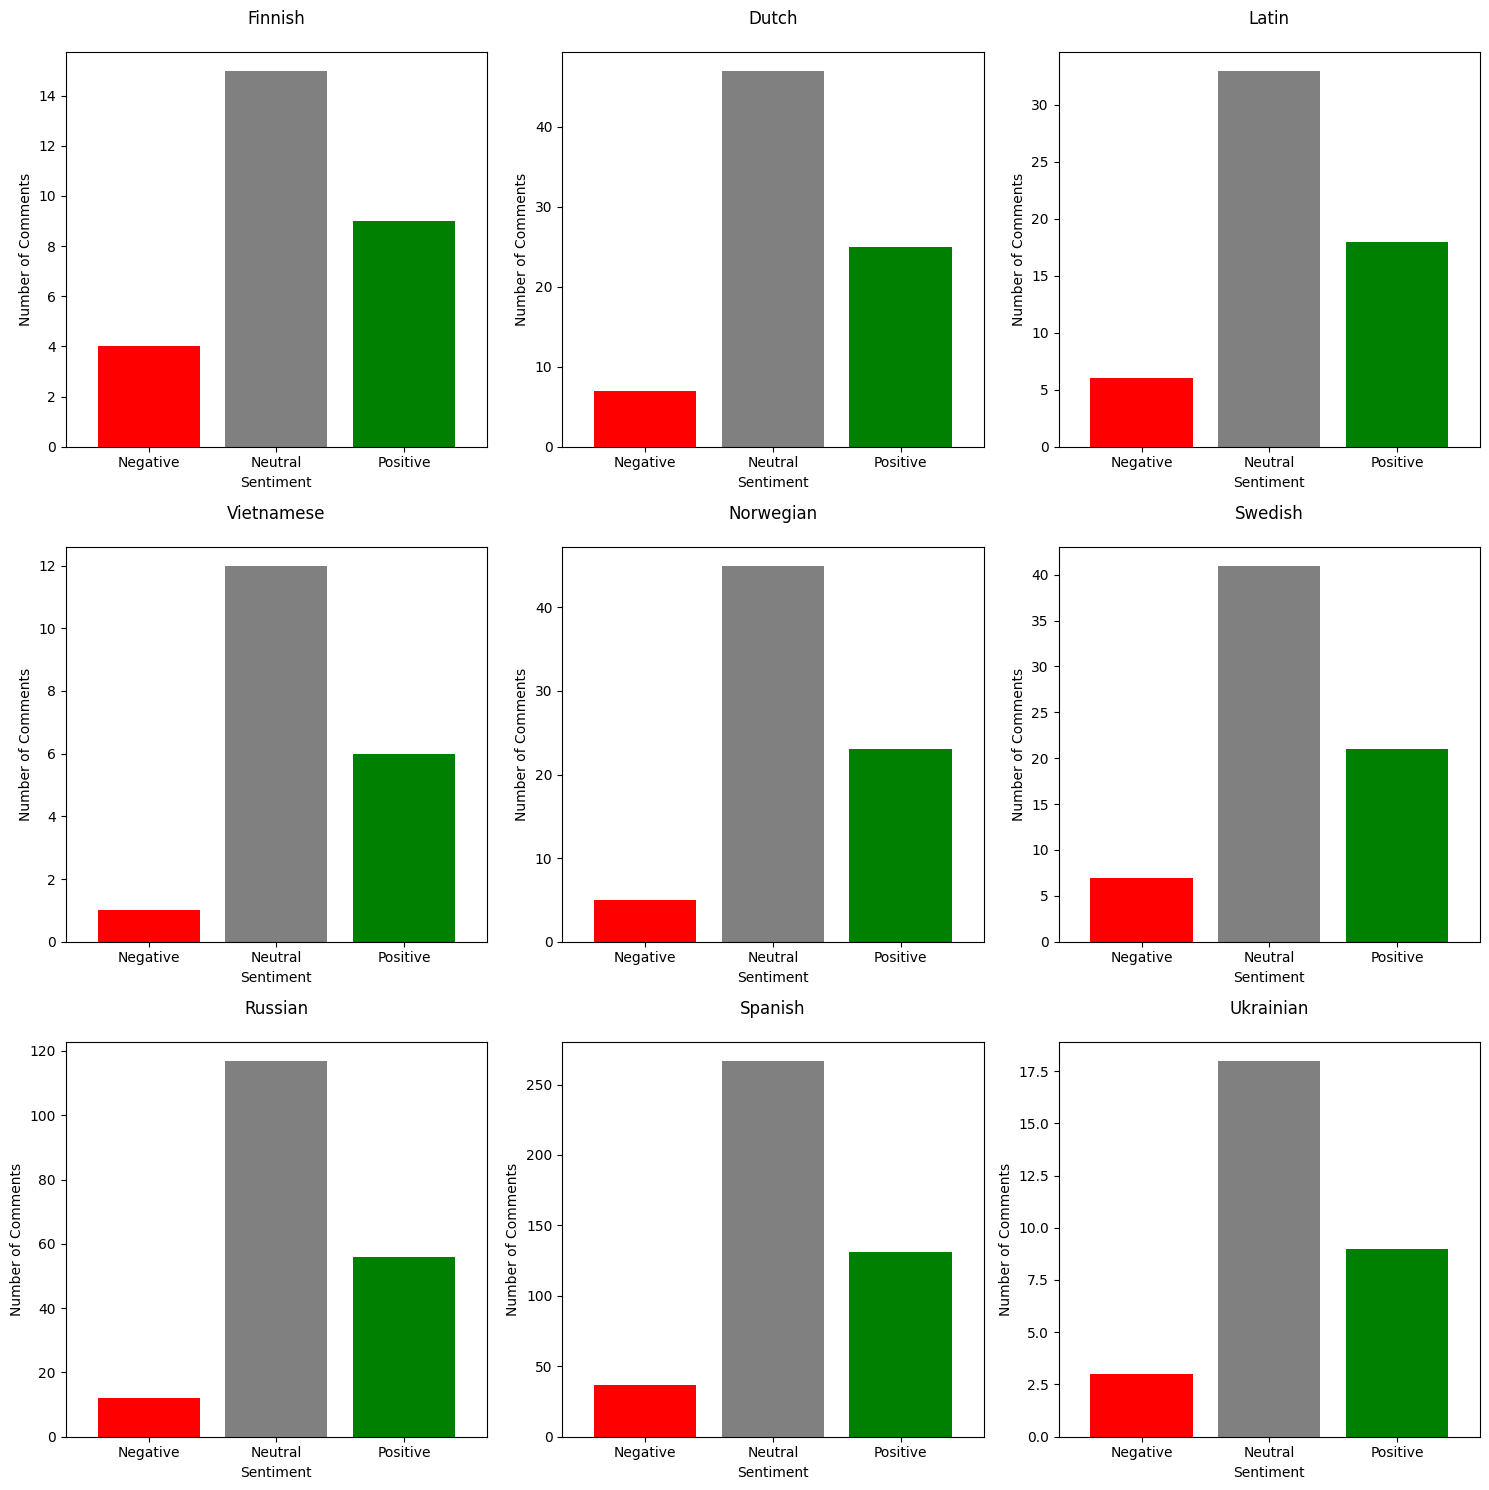

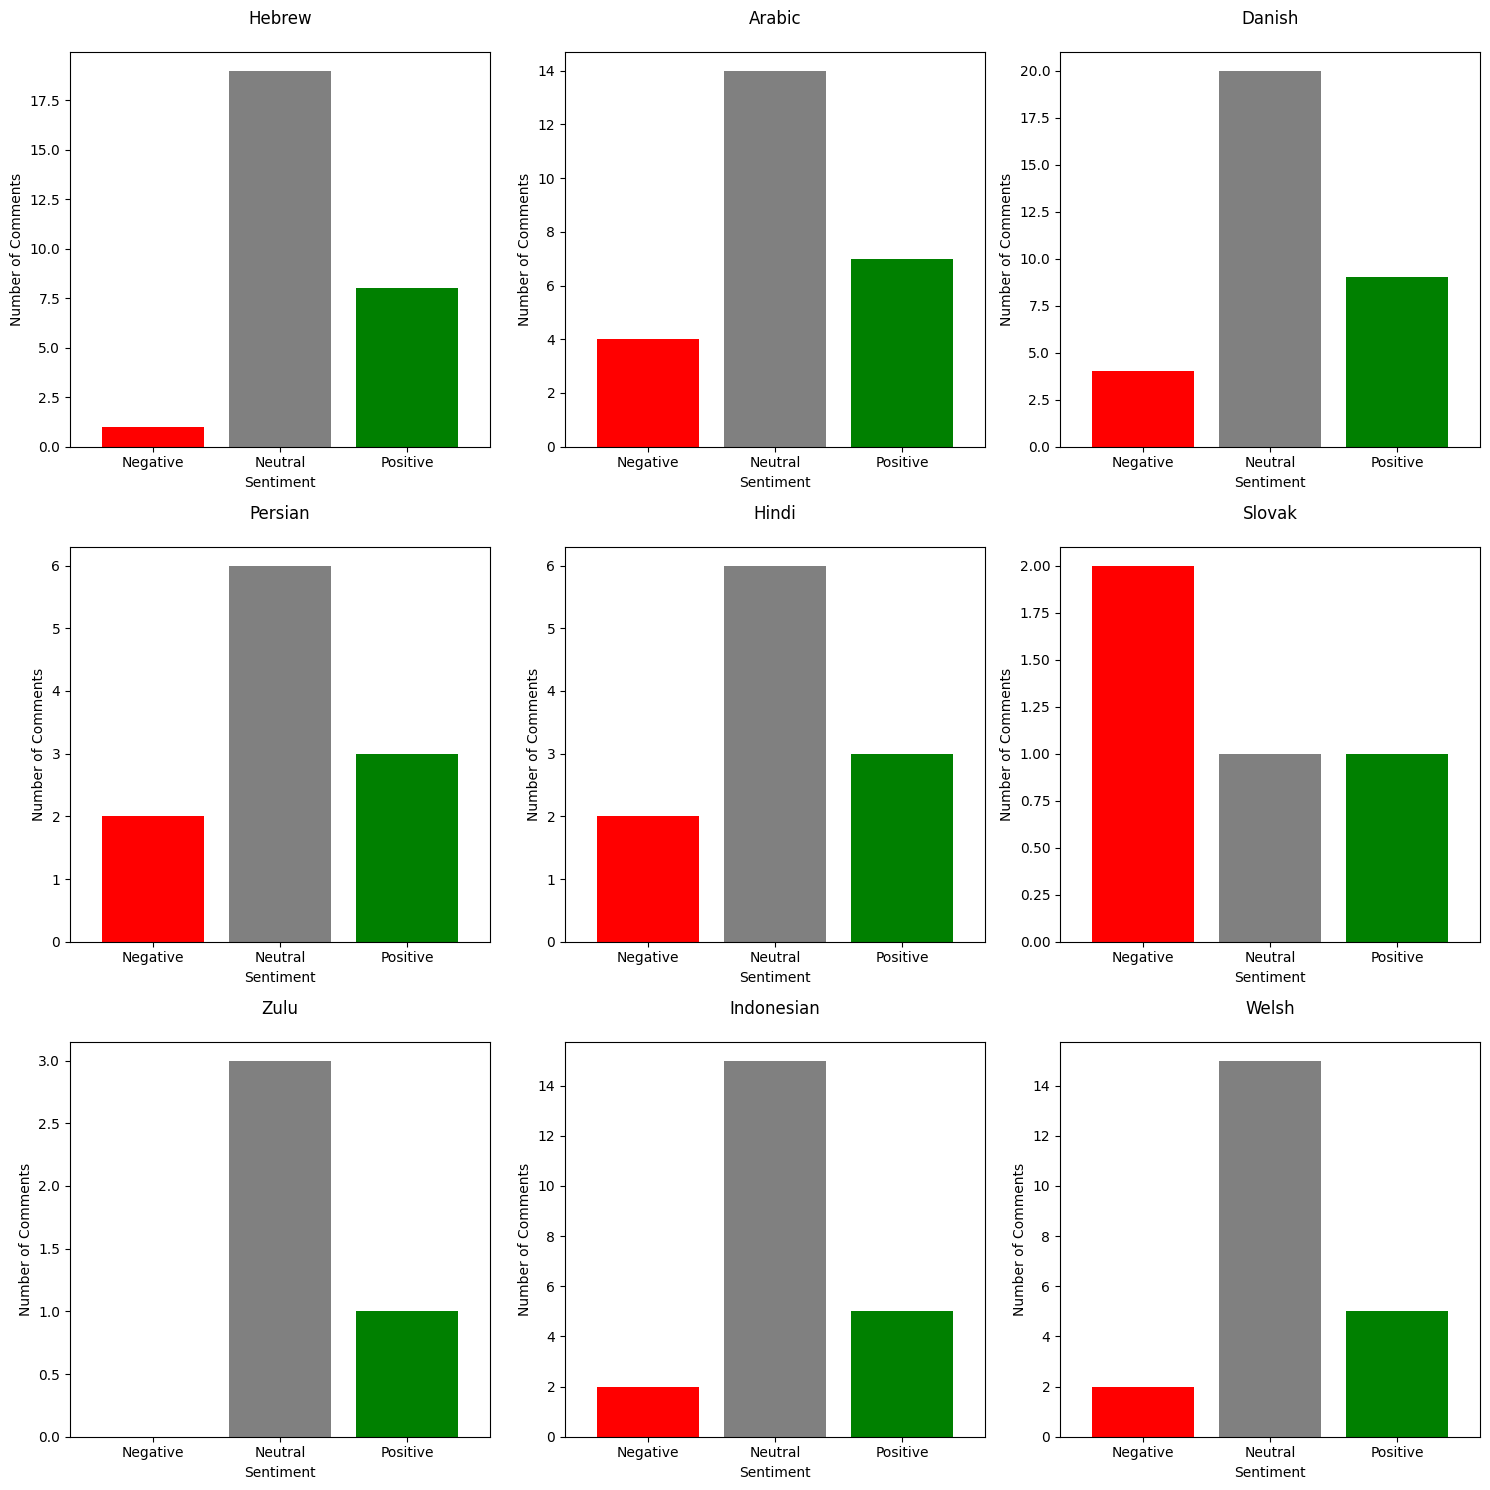

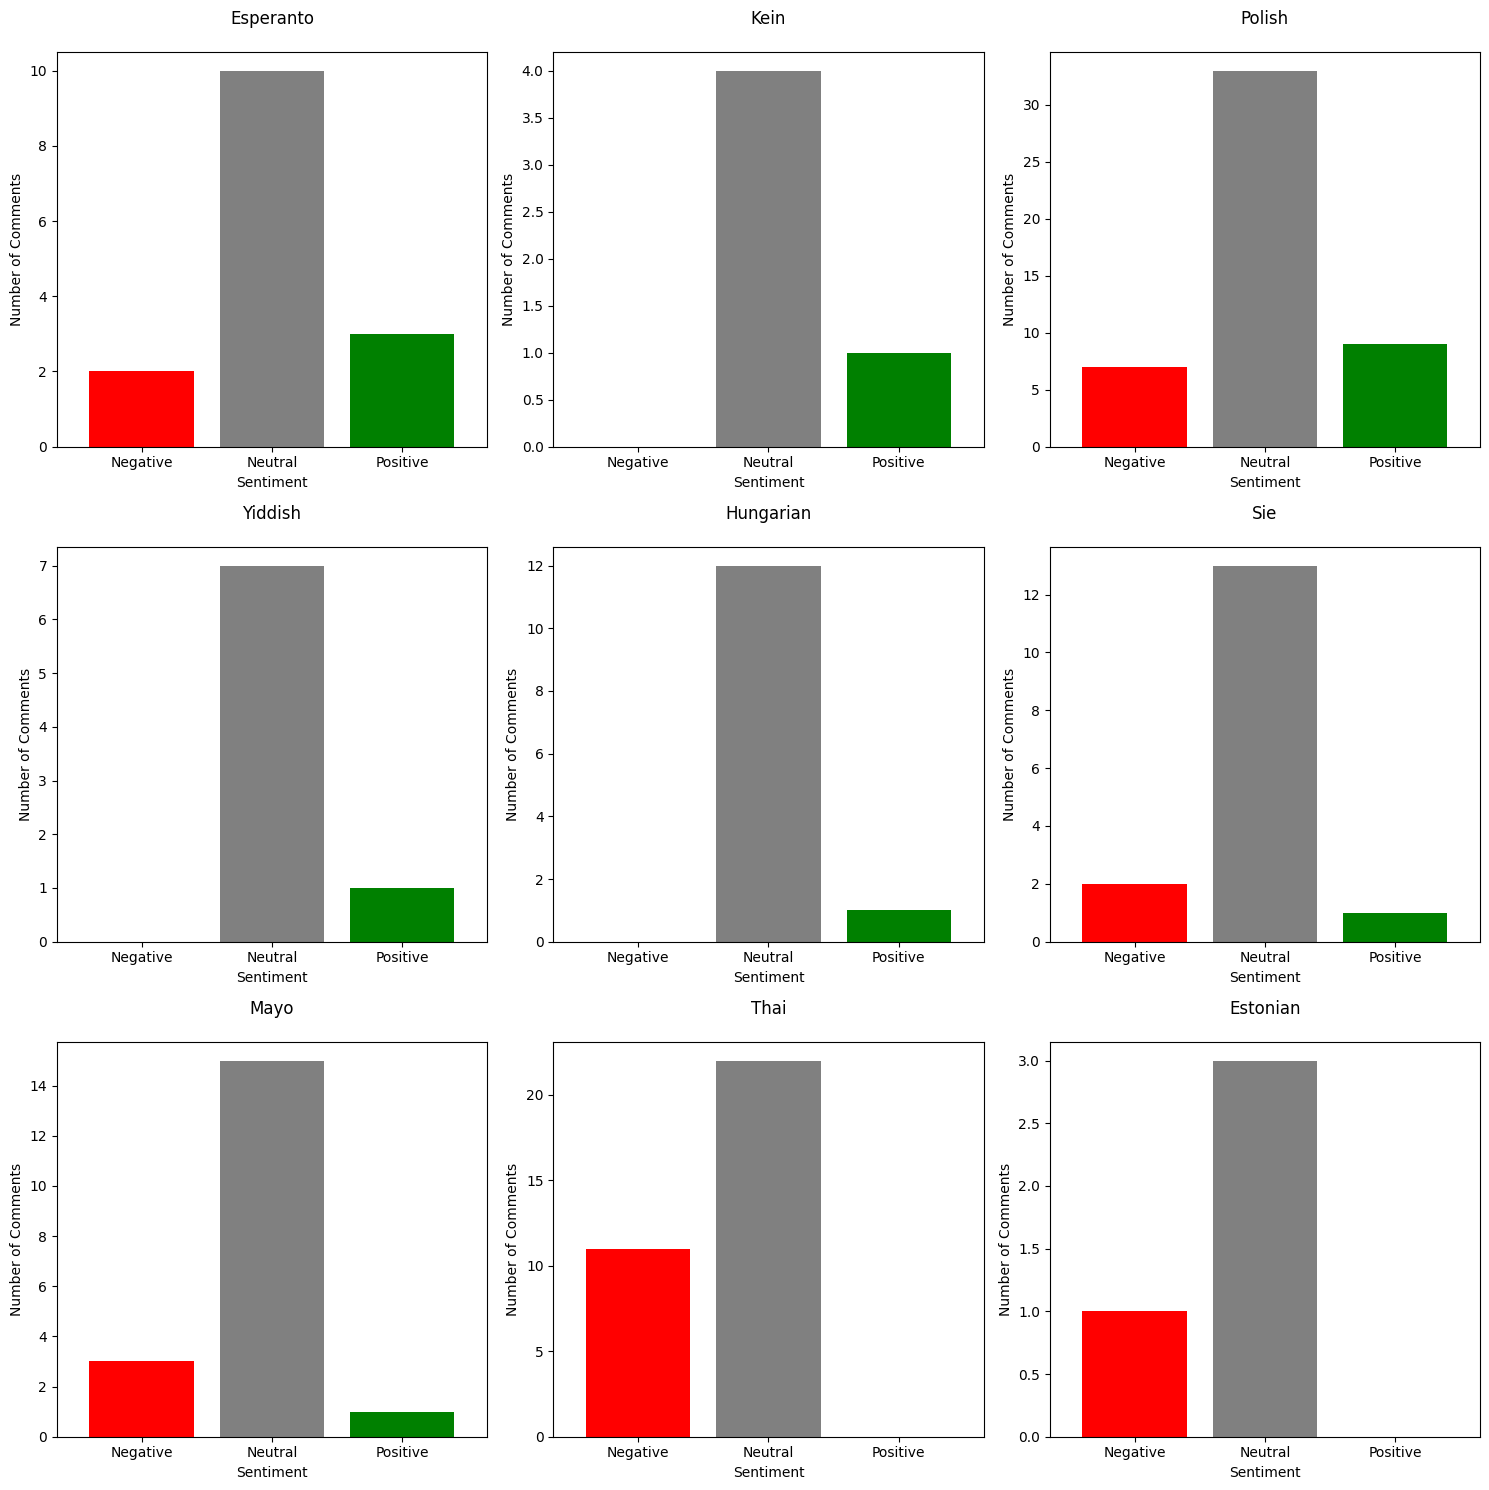

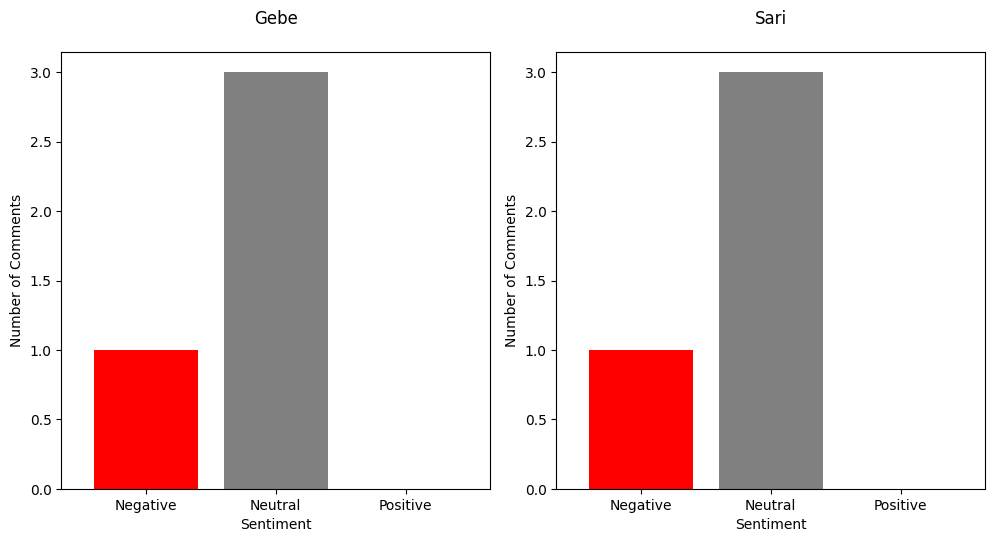

In [22]:
# Create dictionary to store sentiment analysis for each language
language_sentiments = {}

# Analyze sentiment for each language
for language in allowed_languages:
    # Get comments for this language using the lang_ columns
    language_df = df[df[f'lang_{language}'] == 1].copy()
    
    if len(language_df) > 0:  # Only analyze if there are comments for this language
        sentiment_counts = analyze_sentiment(language_df)
        # Calculate percentage of positive sentiment
        total = sentiment_counts.sum()
        pos_pct = (sentiment_counts['Positive'] / total) if total > 0 else 0
        language_sentiments[language] = (sentiment_counts, pos_pct)

# Sort languages by positive sentiment percentage
sorted_languages = sorted(language_sentiments.items(),
                        key=lambda x: x[1][1],
                        reverse=True)

# Plot sentiments for languages in multiple 3x3 grids
languages_per_grid = 9  # 3x3 grid
num_grids = (len(sorted_languages) + languages_per_grid - 1) // languages_per_grid

for grid_num in range(num_grids):
    start_idx = grid_num * languages_per_grid
    end_idx = min(start_idx + languages_per_grid, len(sorted_languages))
    grid_languages = sorted_languages[start_idx:end_idx]
    
    fig = plt.figure(figsize=(15, 15))
    for idx, (language, (sentiment_counts, _)) in enumerate(grid_languages):
        ax = plt.subplot(3, 3, idx + 1)
        sentiment_counts.plot(kind='bar', width=0.8,
                            color=['red', 'gray', 'green'], ax=ax)
        plt.title(f'{language.title()}', pad=20)
        plt.xlabel('Sentiment')
        plt.ylabel('Number of Comments')
        plt.xticks(rotation=0)

    plt.tight_layout()
    plt.show()


## Co-occurance of other words with features

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/miagafarov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


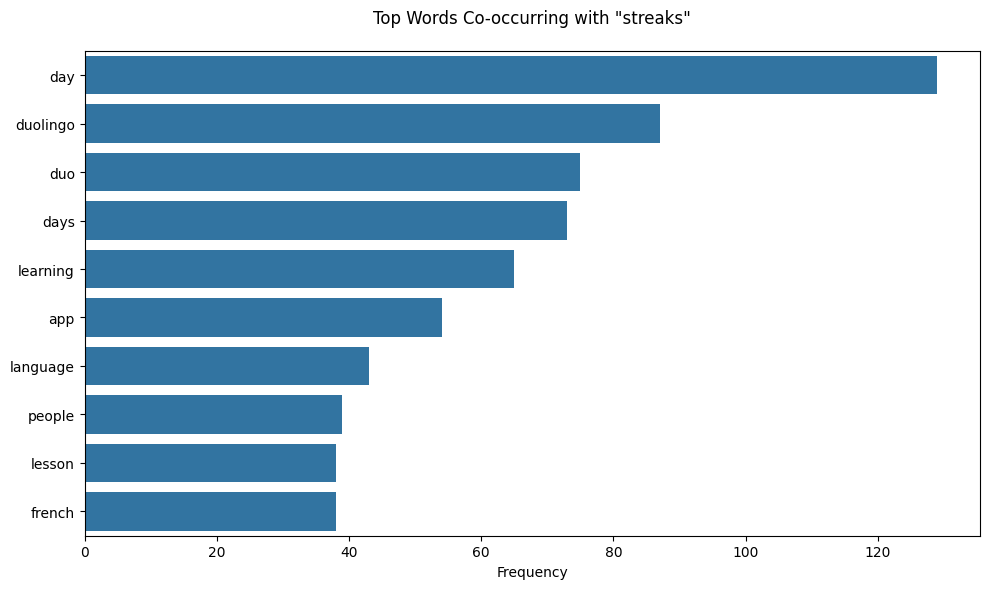


Top words co-occurring with streaks:
day: 129
duolingo: 87
duo: 75
days: 73
learning: 65
app: 54
language: 43
people: 39
lesson: 38
french: 38
--------------------------------------------------


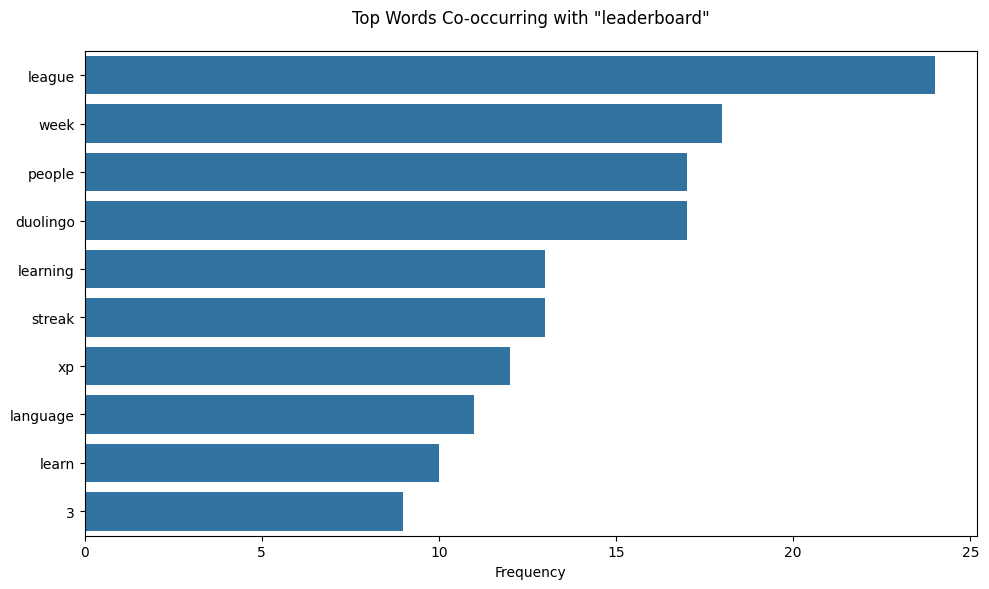


Top words co-occurring with leaderboard:
league: 24
week: 18
people: 17
duolingo: 17
learning: 13
streak: 13
xp: 12
language: 11
learn: 10
3: 9
--------------------------------------------------


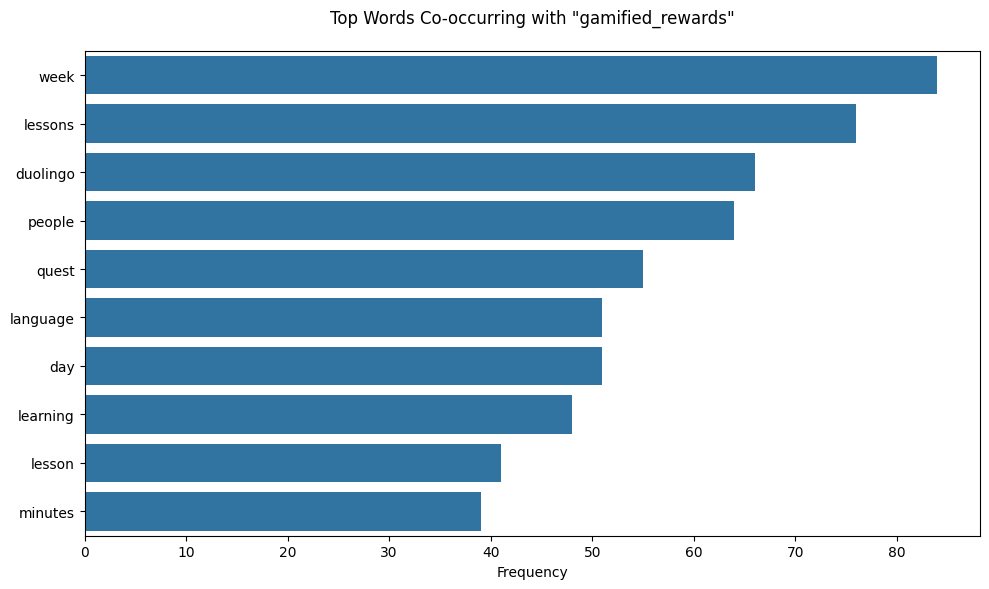


Top words co-occurring with gamified_rewards:
week: 84
lessons: 76
duolingo: 66
people: 64
quest: 55
language: 51
day: 51
learning: 48
lesson: 41
minutes: 39
--------------------------------------------------


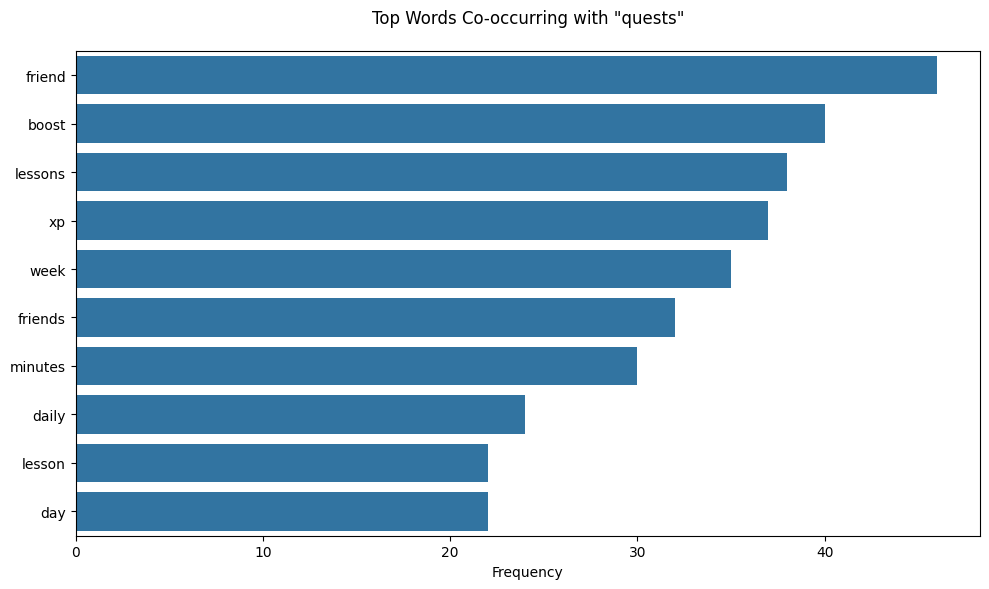


Top words co-occurring with quests:
friend: 46
boost: 40
lessons: 38
xp: 37
week: 35
friends: 32
minutes: 30
daily: 24
lesson: 22
day: 22
--------------------------------------------------


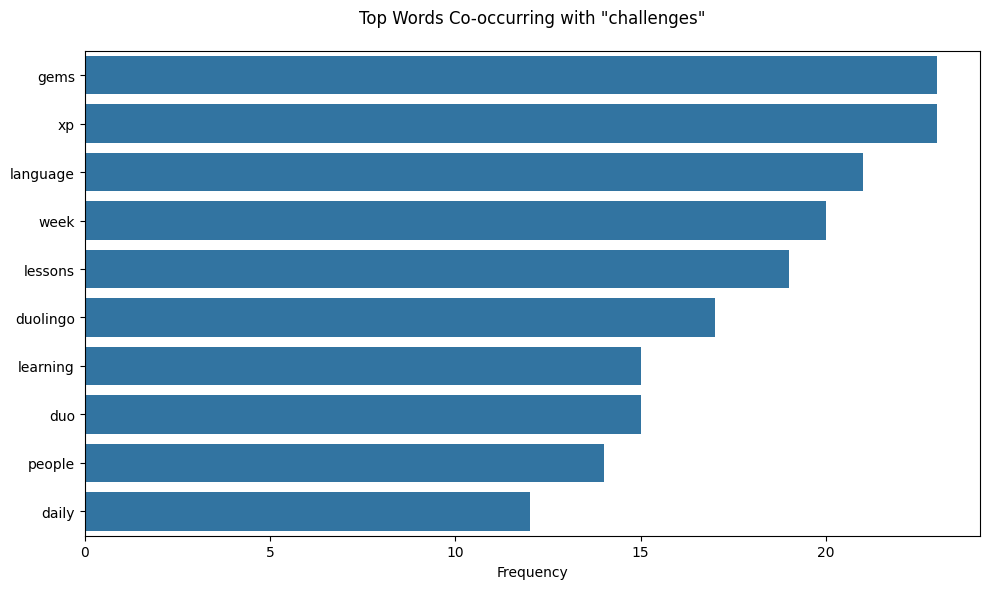


Top words co-occurring with challenges:
gems: 23
xp: 23
language: 21
week: 20
lessons: 19
duolingo: 17
learning: 15
duo: 15
people: 14
daily: 12
--------------------------------------------------


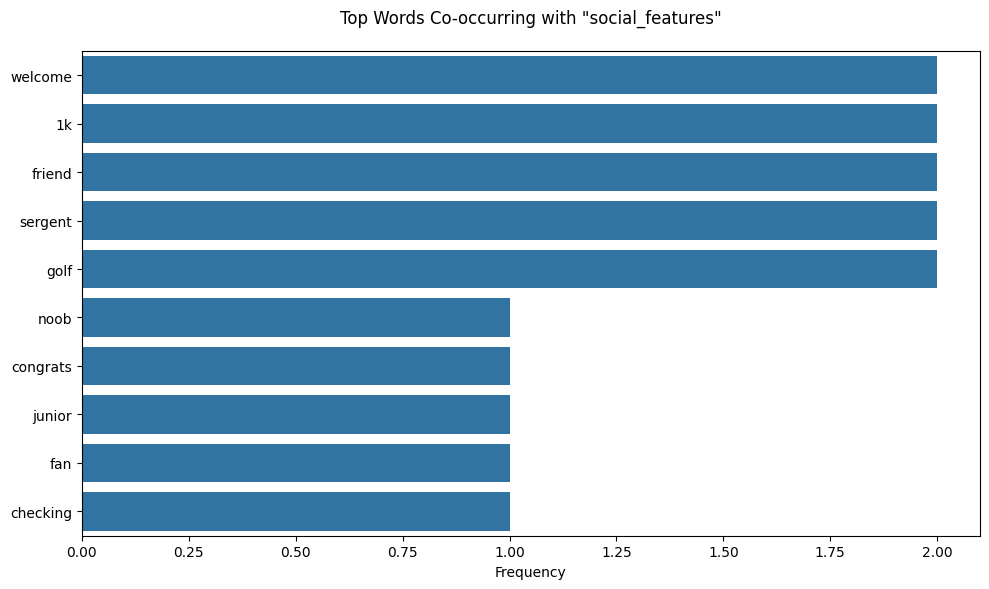


Top words co-occurring with social_features:
welcome: 2
1k: 2
friend: 2
sergent: 2
golf: 2
noob: 1
congrats: 1
junior: 1
fan: 1
checking: 1
--------------------------------------------------


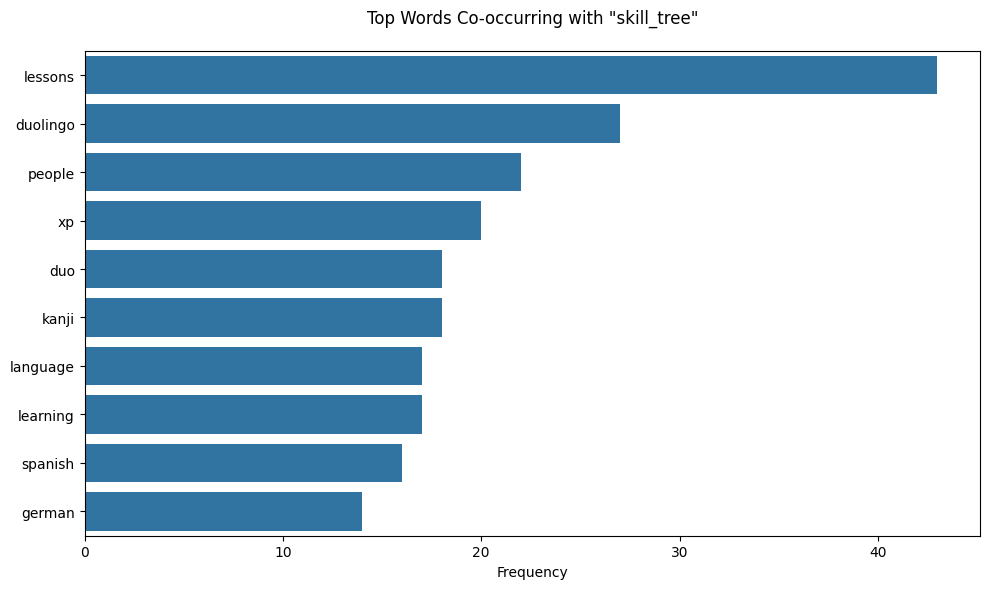


Top words co-occurring with skill_tree:
lessons: 43
duolingo: 27
people: 22
xp: 20
duo: 18
kanji: 18
language: 17
learning: 17
spanish: 16
german: 14
--------------------------------------------------


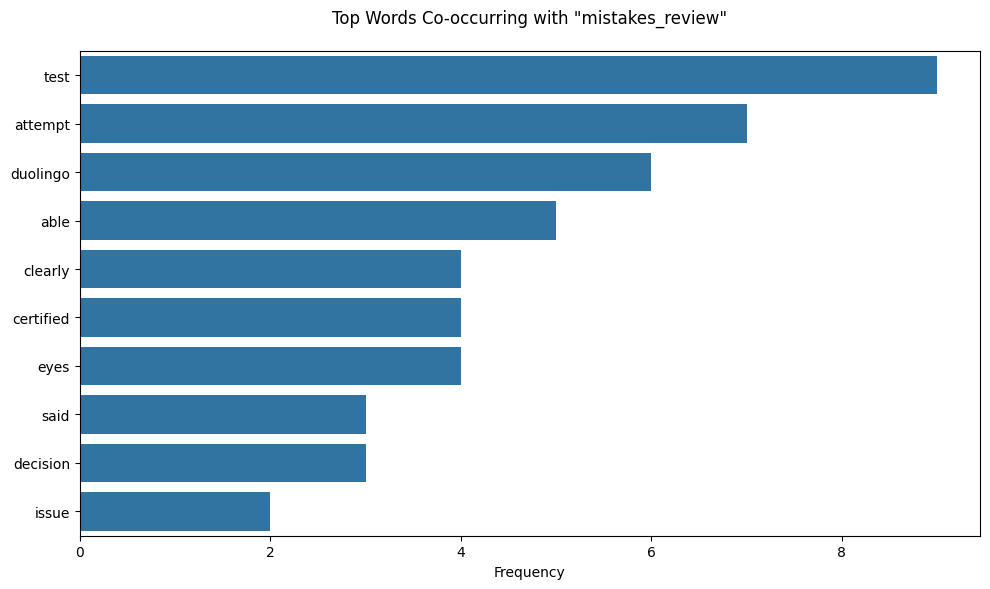


Top words co-occurring with mistakes_review:
test: 9
attempt: 7
duolingo: 6
able: 5
clearly: 4
certified: 4
eyes: 4
said: 3
decision: 3
issue: 2
--------------------------------------------------


In [23]:
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter

# Download required NLTK data
nltk.download('punkt')

def analyze_feature_cooccurrence(df, feature, top_n=10):
    # Get comments that mention this feature
    feature_comments = df[df[feature] == 1]['comment_text'].dropna()
    
    # Tokenize and clean words
    all_words = []
    for comment in feature_comments:
        # Tokenize and convert to lowercase
        tokens = word_tokenize(comment.lower())
        # Filter out stopwords, punctuation, and the feature words themselves
        feature_words = [word for sublist in feature_dict[feature] for word in sublist]
        words = [word for word in tokens 
                if word.isalnum() 
                and word not in custom_stopwords 
                and word not in feature_words]
        all_words.extend(words)
    
    # Count word frequencies
    word_counts = Counter(all_words)
    
    # Get top N most common words
    top_words = word_counts.most_common(top_n)
    
    return top_words

# Analyze and plot for each feature
for feature in feature_dict:
    top_words = analyze_feature_cooccurrence(df, feature)
    
    if len(top_words) > 0:
        # Create bar plot
        plt.figure(figsize=(10, 6))
        words, counts = zip(*top_words)
        sns.barplot(x=list(counts), y=list(words))
        plt.title(f'Top Words Co-occurring with "{feature}"', pad=20)
        plt.xlabel('Frequency')
        plt.tight_layout()
        plt.show()
        
        print(f"\nTop words co-occurring with {feature}:")
        for word, count in top_words:
            print(f"{word}: {count}")
        print("-" * 50)


Analyzing proximity co-occurrence for 'streaks':


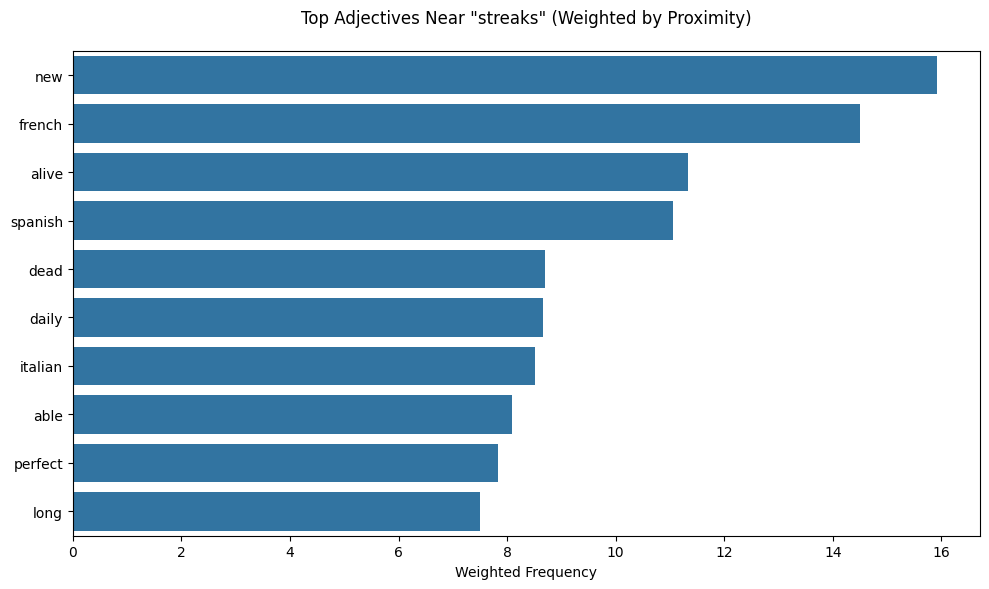


Top nearby adjectives (weighted by proximity):
new: 15.92
french: 14.50
alive: 11.33
spanish: 11.05
dead: 8.70
daily: 8.67
italian: 8.52
able: 8.08
perfect: 7.83
long: 7.50
--------------------------------------------------

Analyzing proximity co-occurrence for 'leaderboard':


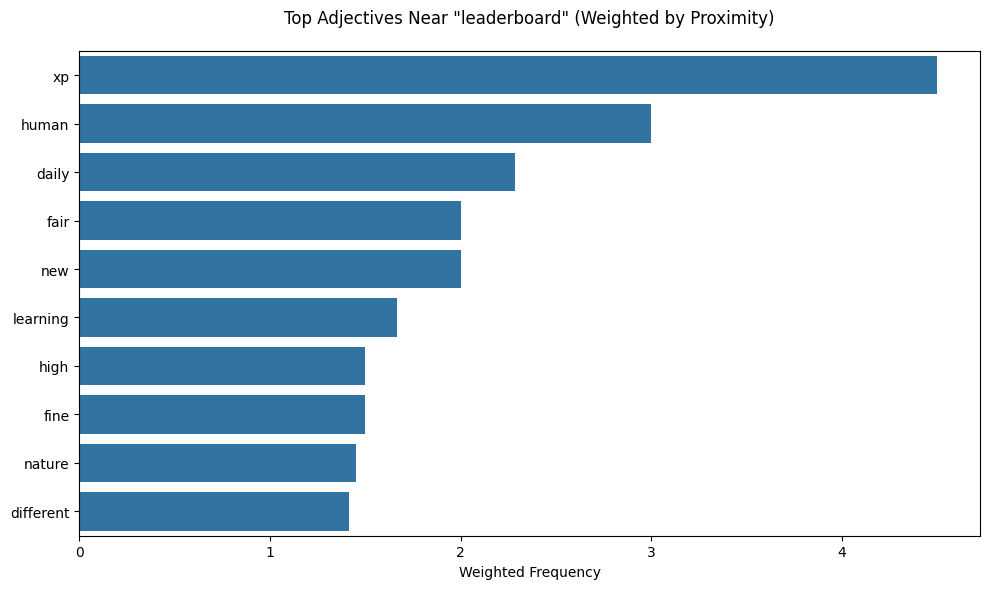


Top nearby adjectives (weighted by proximity):
xp: 4.50
human: 3.00
daily: 2.28
fair: 2.00
new: 2.00
learning: 1.67
high: 1.50
fine: 1.50
nature: 1.45
different: 1.42
--------------------------------------------------

Analyzing proximity co-occurrence for 'gamified_rewards':


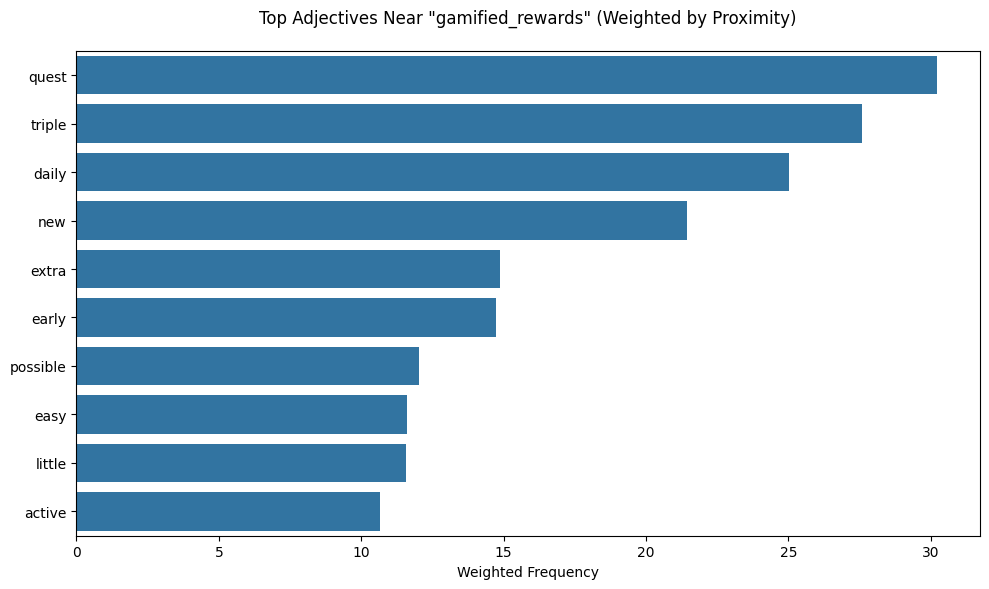


Top nearby adjectives (weighted by proximity):
quest: 30.22
triple: 27.60
daily: 25.03
new: 21.45
extra: 14.88
early: 14.72
possible: 12.02
easy: 11.60
little: 11.57
active: 10.65
--------------------------------------------------

Analyzing proximity co-occurrence for 'quests':


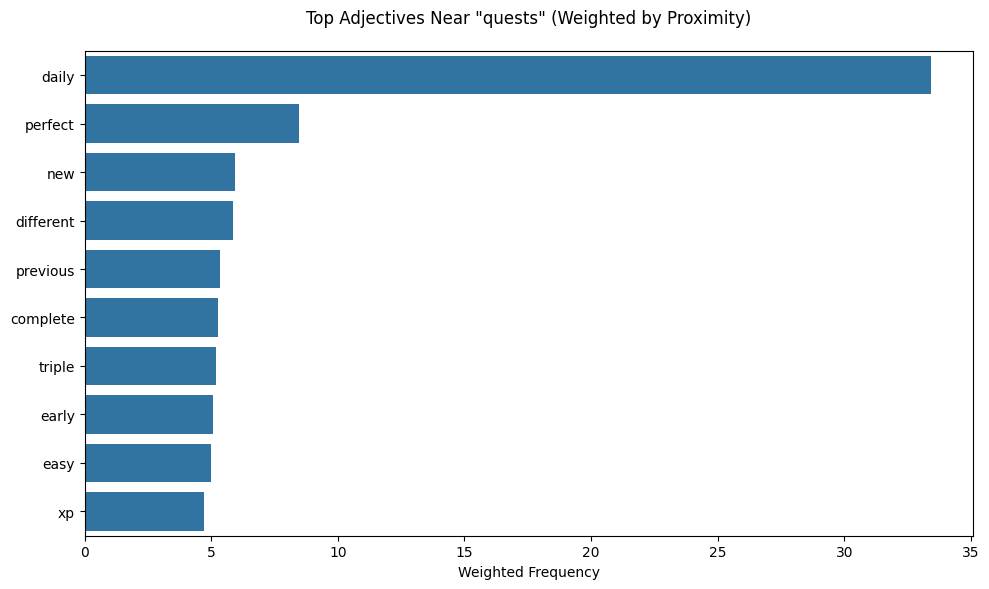


Top nearby adjectives (weighted by proximity):
daily: 33.40
perfect: 8.47
new: 5.95
different: 5.87
previous: 5.33
complete: 5.28
triple: 5.20
early: 5.07
easy: 5.00
xp: 4.70
--------------------------------------------------

Analyzing proximity co-occurrence for 'challenges':


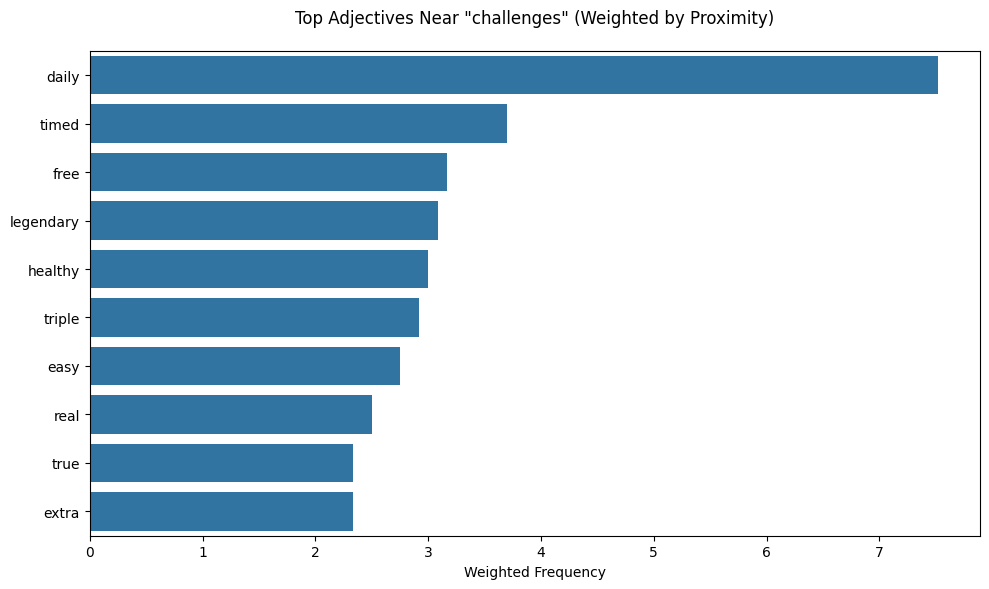


Top nearby adjectives (weighted by proximity):
daily: 7.52
timed: 3.70
free: 3.17
legendary: 3.08
healthy: 3.00
triple: 2.92
easy: 2.75
real: 2.50
true: 2.33
extra: 2.33
--------------------------------------------------

Analyzing proximity co-occurrence for 'interactive_exercies':

Analyzing proximity co-occurrence for 'social_features':


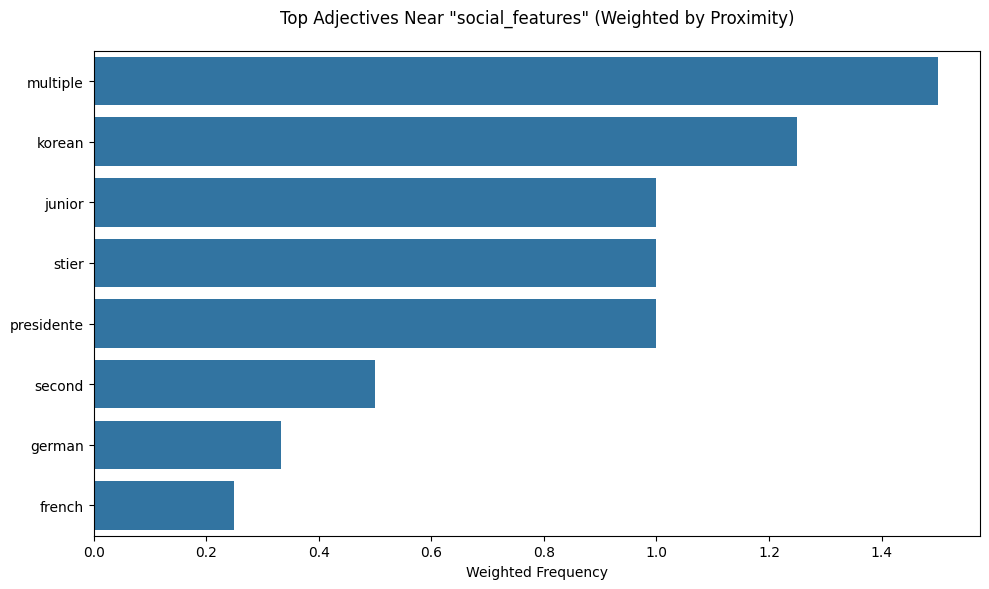


Top nearby adjectives (weighted by proximity):
multiple: 1.50
korean: 1.25
junior: 1.00
stier: 1.00
presidente: 1.00
second: 0.50
german: 0.33
french: 0.25
--------------------------------------------------

Analyzing proximity co-occurrence for 'skill_tree':


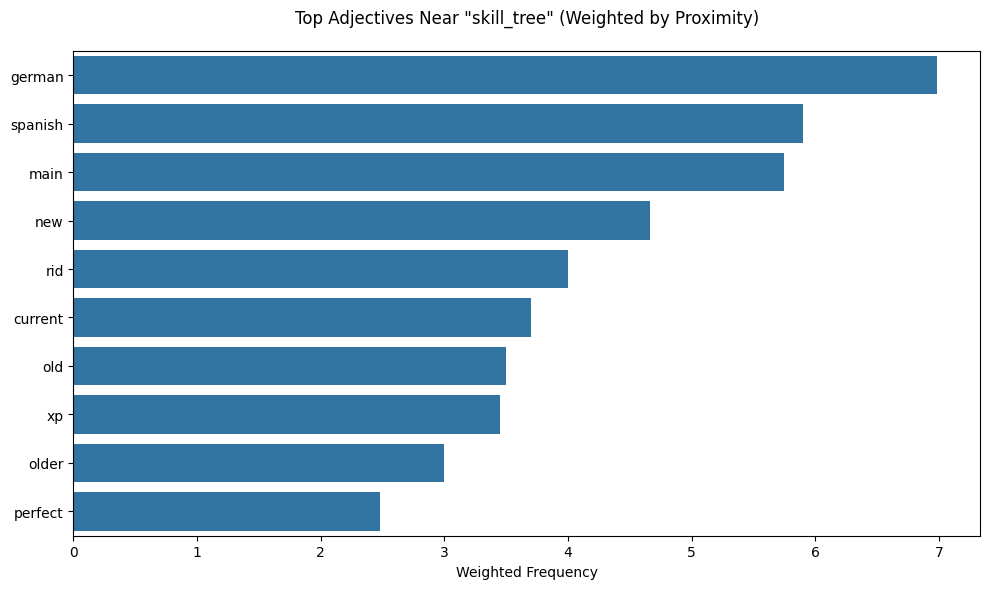


Top nearby adjectives (weighted by proximity):
german: 6.98
spanish: 5.90
main: 5.75
new: 4.67
rid: 4.00
current: 3.70
old: 3.50
xp: 3.45
older: 3.00
perfect: 2.48
--------------------------------------------------

Analyzing proximity co-occurrence for 'mistakes_review':


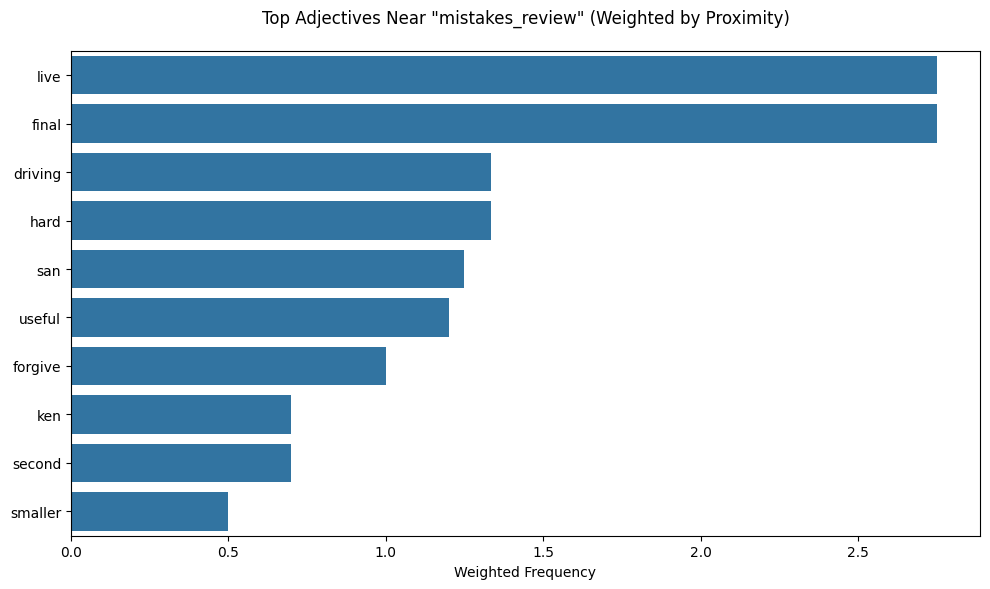


Top nearby adjectives (weighted by proximity):
live: 2.75
final: 2.75
driving: 1.33
hard: 1.33
san: 1.25
useful: 1.20
forgive: 1.00
ken: 0.70
second: 0.70
smaller: 0.50
--------------------------------------------------


In [24]:
def analyze_proximity_cooccurrence(df, feature, window_size=5, top_n=10, adjectives_only=True):
    # Get comments that mention this feature
    feature_comments = df[df[feature] == 1]['comment_text'].dropna()
    
    # Get feature keywords
    feature_words = set([word for sublist in feature_dict[feature] for word in sublist])
    
    # Store words with their distances
    word_distances = []
    
    for comment in feature_comments:
        tokens = word_tokenize(comment.lower())
        
        # If adjectives_only flag is True, tag parts of speech and filter for adjectives
        if adjectives_only:
            # Tag parts of speech
            tagged_tokens = nltk.pos_tag(tokens)
            # Create a filtered list with only adjectives and feature words
            filtered_indices = []
            filtered_tokens = []
            
            for i, (word, tag) in enumerate(tagged_tokens):
                if tag.startswith('JJ') or word in feature_words:  # JJ, JJR, JJS are adjective tags
                    filtered_indices.append(i)
                    filtered_tokens.append(word)
            
            # Find positions of feature words in the filtered list
            feature_positions = [i for i, word in enumerate(filtered_tokens) 
                               if word in feature_words]
            
            # For each feature word position, look for nearby adjectives within window
            for pos in feature_positions:
                # Define window boundaries in the filtered list
                start = max(0, pos - window_size)
                end = min(len(filtered_tokens), pos + window_size + 1)
                
                # Collect adjectives and their distances
                for i in range(start, end):
                    if i != pos:  # Skip the feature word itself
                        word = filtered_tokens[i]
                        if (word.isalnum() and 
                            word not in custom_stopwords and 
                            word not in feature_words):
                            distance = abs(i - pos)
                            word_distances.append((word, distance))
        else:
            # Original logic for all words
            # Find positions of feature words
            feature_positions = [i for i, word in enumerate(tokens) 
                               if word in feature_words]
            
            # For each word position, look for nearby words within window
            for pos in feature_positions:
                # Define window boundaries
                start = max(0, pos - window_size)
                end = min(len(tokens), pos + window_size + 1)
                
                # Collect words and their distances
                for i in range(start, end):
                    if i != pos:  # Skip the feature word itself
                        word = tokens[i]
                        if (word.isalnum() and 
                            word not in custom_stopwords and 
                            word not in feature_words):
                            distance = abs(i - pos)
                            word_distances.append((word, distance))
    
    # Count words, weighing by inverse distance
    weighted_counts = {}
    for word, distance in word_distances:
        weight = 1 / distance  # Closer words get higher weight
        weighted_counts[word] = weighted_counts.get(word, 0) + weight
    
    # Get top N words by weighted count
    top_words = sorted(weighted_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    return top_words

# Analyze and plot for a specific feature
for feature in feature_dict:
    print(f"\nAnalyzing proximity co-occurrence for '{feature}':")
    top_words = analyze_proximity_cooccurrence(df, feature)
    
    if len(top_words) > 0:
        # Create bar plot
        plt.figure(figsize=(10, 6))
        words, weights = zip(*top_words)
        sns.barplot(x=list(weights), y=list(words))
        plt.title(f'Top Adjectives Near "{feature}" (Weighted by Proximity)', pad=20)
        plt.xlabel('Weighted Frequency')
        plt.tight_layout()
        plt.show()
        
        print("\nTop nearby adjectives (weighted by proximity):")
        for word, weight in top_words:
            print(f"{word}: {weight:.2f}")
        print("-" * 50)
        
    # # Also analyze with all words (not just adjectives)
    # print(f"\nAnalyzing all words near '{feature}':")
    # all_words_top = analyze_proximity_cooccurrence(df, feature, adjectives_only=False)
    
    # if len(all_words_top) > 0:
    #     # Create bar plot for all words
    #     plt.figure(figsize=(10, 6))
    #     all_words, all_weights = zip(*all_words_top)
    #     sns.barplot(x=list(all_weights), y=list(all_words))
    #     plt.title(f'Top Words Near "{feature}" (Weighted by Proximity)', pad=20)
    #     plt.xlabel('Weighted Frequency')
    #     plt.tight_layout()
    #     plt.show()
        
    #     print("\nTop nearby words (weighted by proximity):")
    #     for word, weight in all_words_top:
    #         print(f"{word}: {weight:.2f}")
    #     print("-" * 50)
    


Analyzing proximity co-occurrence for 'streaks':


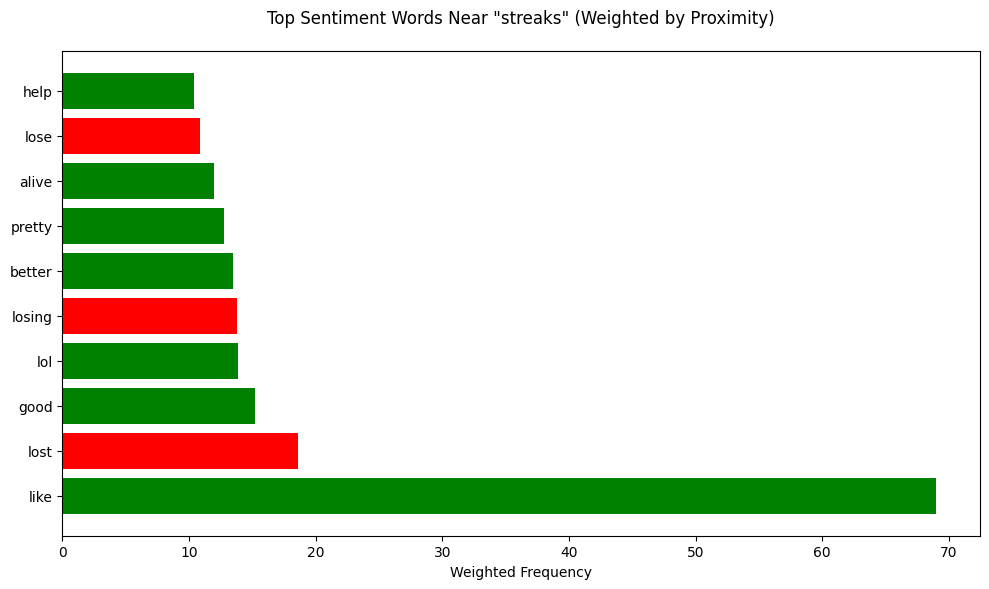


Top nearby sentiment words (weighted by proximity):
like: 69.00 (positive, score: 0.36)
lost: 18.58 (negative, score: -0.32)
good: 15.23 (positive, score: 0.44)
lol: 13.83 (positive, score: 0.42)
losing: 13.82 (negative, score: -0.38)
better: 13.45 (positive, score: 0.44)
pretty: 12.73 (positive, score: 0.49)
alive: 12.00 (positive, score: 0.38)
lose: 10.83 (negative, score: -0.40)
help: 10.40 (positive, score: 0.40)
--------------------------------------------------

Analyzing proximity co-occurrence for 'leaderboard':


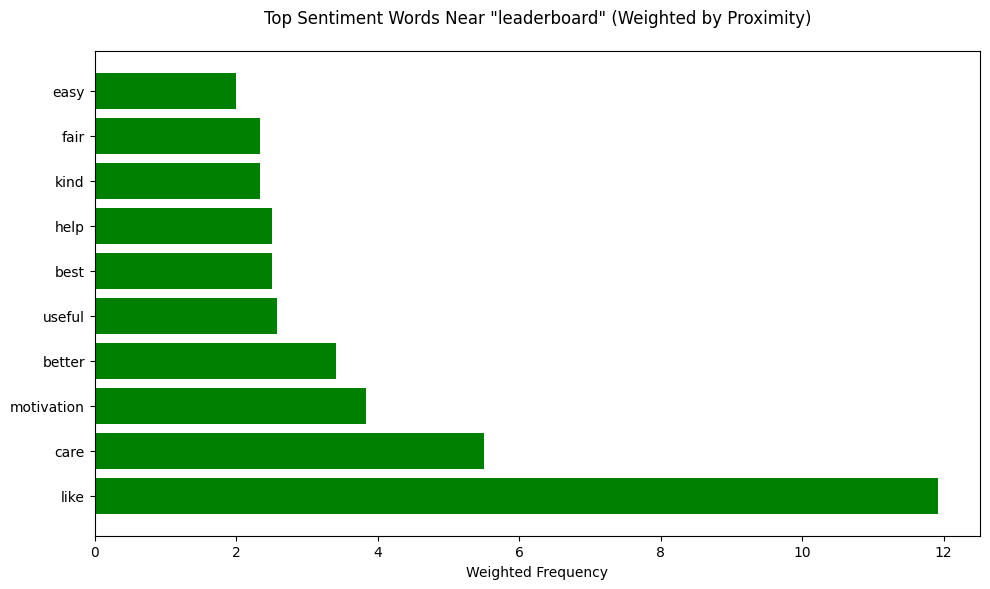


Top nearby sentiment words (weighted by proximity):
like: 11.92 (positive, score: 0.36)
care: 5.50 (positive, score: 0.49)
motivation: 3.83 (positive, score: 0.34)
better: 3.42 (positive, score: 0.44)
useful: 2.58 (positive, score: 0.44)
best: 2.50 (positive, score: 0.64)
help: 2.50 (positive, score: 0.40)
kind: 2.33 (positive, score: 0.53)
fair: 2.33 (positive, score: 0.32)
easy: 2.00 (positive, score: 0.44)
--------------------------------------------------

Analyzing proximity co-occurrence for 'gamified_rewards':


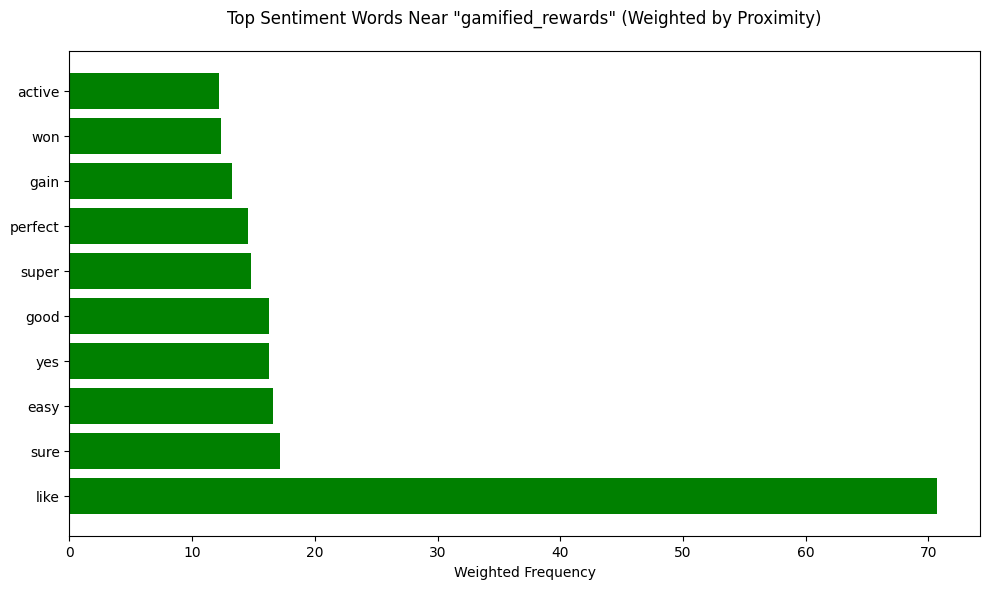


Top nearby sentiment words (weighted by proximity):
like: 70.68 (positive, score: 0.36)
sure: 17.17 (positive, score: 0.32)
easy: 16.60 (positive, score: 0.44)
yes: 16.28 (positive, score: 0.40)
good: 16.27 (positive, score: 0.44)
super: 14.83 (positive, score: 0.60)
perfect: 14.53 (positive, score: 0.57)
gain: 13.23 (positive, score: 0.53)
won: 12.33 (positive, score: 0.57)
active: 12.20 (positive, score: 0.40)
--------------------------------------------------

Analyzing proximity co-occurrence for 'quests':


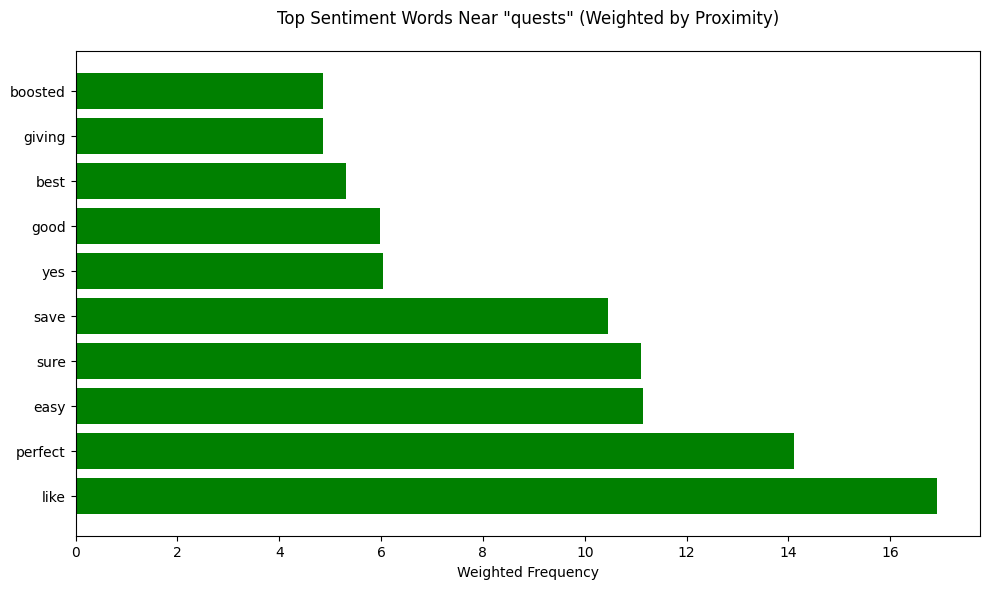


Top nearby sentiment words (weighted by proximity):
like: 16.92 (positive, score: 0.36)
perfect: 14.10 (positive, score: 0.57)
easy: 11.15 (positive, score: 0.44)
sure: 11.10 (positive, score: 0.32)
save: 10.45 (positive, score: 0.49)
yes: 6.03 (positive, score: 0.40)
good: 5.98 (positive, score: 0.44)
best: 5.32 (positive, score: 0.64)
giving: 4.87 (positive, score: 0.34)
boosted: 4.87 (positive, score: 0.36)
--------------------------------------------------

Analyzing proximity co-occurrence for 'challenges':


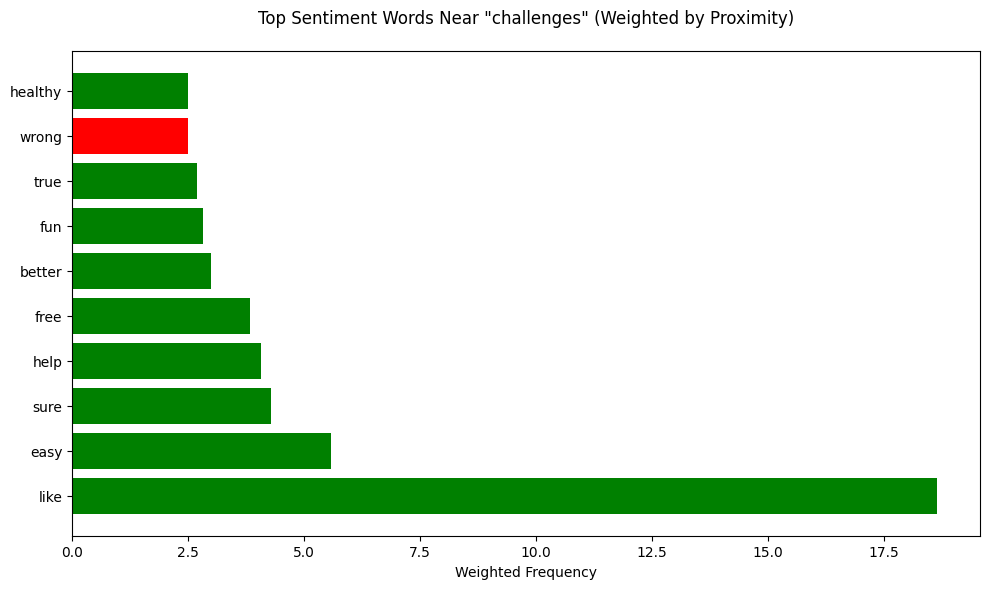


Top nearby sentiment words (weighted by proximity):
like: 18.63 (positive, score: 0.36)
easy: 5.58 (positive, score: 0.44)
sure: 4.28 (positive, score: 0.32)
help: 4.08 (positive, score: 0.40)
free: 3.83 (positive, score: 0.51)
better: 3.00 (positive, score: 0.44)
fun: 2.83 (positive, score: 0.51)
true: 2.70 (positive, score: 0.42)
wrong: 2.50 (negative, score: -0.48)
healthy: 2.50 (positive, score: 0.40)
--------------------------------------------------

Analyzing proximity co-occurrence for 'interactive_exercies':

Analyzing proximity co-occurrence for 'social_features':


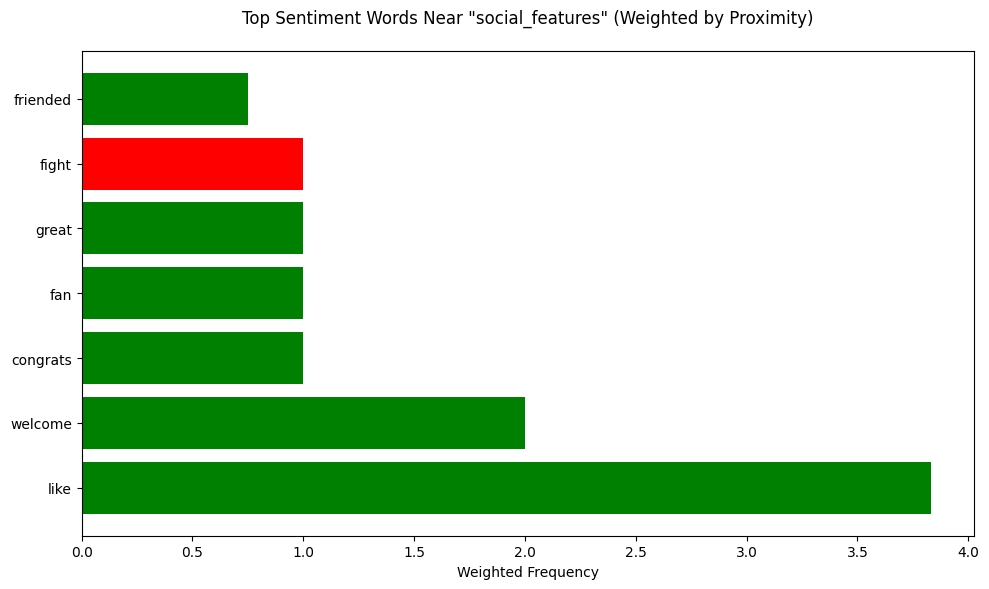


Top nearby sentiment words (weighted by proximity):
like: 3.83 (positive, score: 0.36)
welcome: 2.00 (positive, score: 0.46)
congrats: 1.00 (positive, score: 0.53)
fan: 1.00 (positive, score: 0.32)
great: 1.00 (positive, score: 0.62)
fight: 1.00 (negative, score: -0.38)
friended: 0.75 (positive, score: 0.40)
--------------------------------------------------

Analyzing proximity co-occurrence for 'skill_tree':


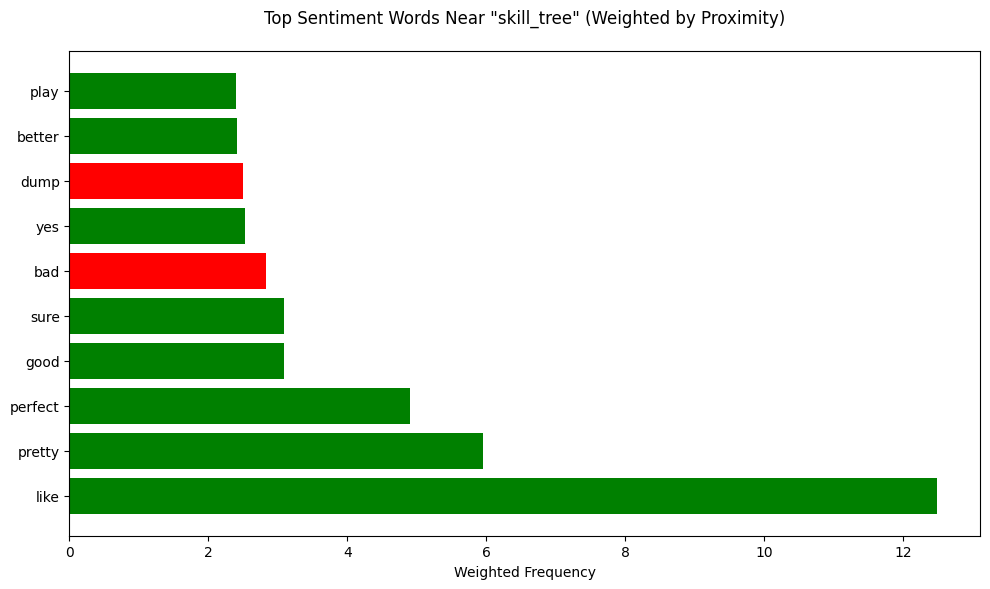


Top nearby sentiment words (weighted by proximity):
like: 12.48 (positive, score: 0.36)
pretty: 5.95 (positive, score: 0.49)
perfect: 4.90 (positive, score: 0.57)
good: 3.08 (positive, score: 0.44)
sure: 3.08 (positive, score: 0.32)
bad: 2.83 (negative, score: -0.54)
yes: 2.53 (positive, score: 0.40)
dump: 2.50 (negative, score: -0.38)
better: 2.42 (positive, score: 0.44)
play: 2.40 (positive, score: 0.34)
--------------------------------------------------

Analyzing proximity co-occurrence for 'mistakes_review':


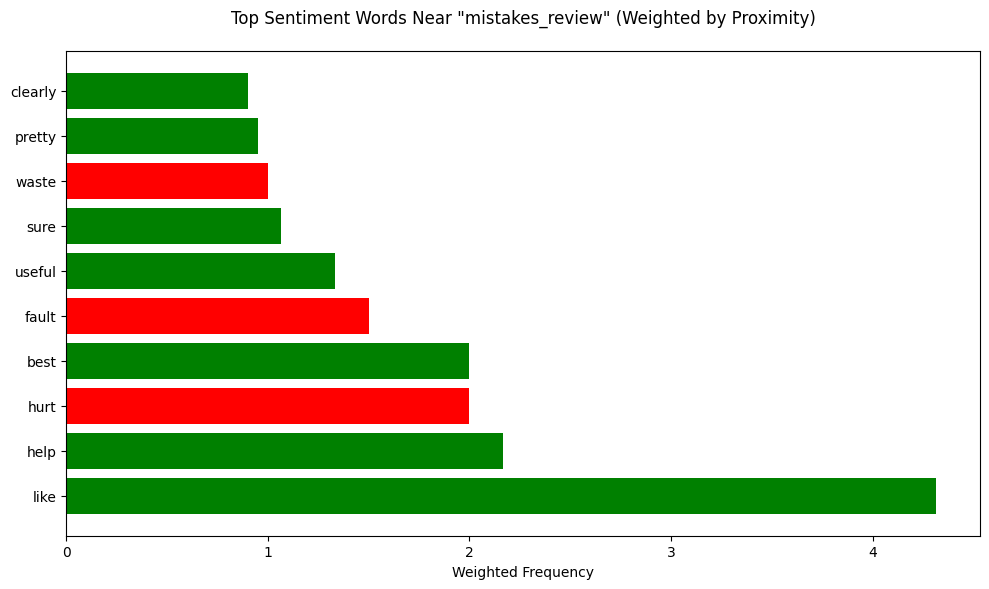


Top nearby sentiment words (weighted by proximity):
like: 4.32 (positive, score: 0.36)
help: 2.17 (positive, score: 0.40)
hurt: 2.00 (negative, score: -0.53)
best: 2.00 (positive, score: 0.64)
fault: 1.50 (negative, score: -0.40)
useful: 1.33 (positive, score: 0.44)
sure: 1.07 (positive, score: 0.32)
waste: 1.00 (negative, score: -0.42)
pretty: 0.95 (positive, score: 0.49)
clearly: 0.90 (positive, score: 0.40)
--------------------------------------------------


In [25]:
def analyze_proximity_cooccurrence_sentimental(df, feature, window_size=5, top_n=10, sentiment_words_only=True):
    

    custom_stopwords = [
        "streak", "streaks",
        "leaderboard", "leaderboards", 
        "leader", "leaders", "competitive", "ranking", "rank", "ranks", "race",
        "boost", "boosts", "achievement", "achievements", "badge",
          "badges", "trophy", "throphies", "xp", "league", "leagues", "diamond", "diamonds",
        "quest", "quests",
        "challenge", "challenges", "competition", "competitions", "contest", "contests", "goals",
        "interactive", "exercises",
        "club", "clubs",
        "tree", "trees", "roadmap", "roadmaps", "path", "paths",
        "mistake", "mistakes", "error", "errors", "review", "reviews", "correction", "corrections",
        "reward", "friend", "friends"
    ]
    # Get comments that mention this feature
    feature_comments = df[df[feature] == 1]['comment_text'].dropna()
    
    # Get feature keywords
    feature_words = set([word for sublist in feature_dict[feature] for word in sublist])
    
    # Store words with their distances
    word_distances = []
    
    # Load sentiment lexicon
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    sid = SentimentIntensityAnalyzer()
    
    for comment in feature_comments:
        tokens = word_tokenize(comment.lower())
        
        # If sentiment_words_only flag is True, filter for words with strong sentiment
        if sentiment_words_only:
            # Create a filtered list with only sentiment words and feature words
            filtered_indices = []
            filtered_tokens = []
            
            for i, word in enumerate(tokens):
                # Check if it's a feature word or has strong sentiment
                sentiment_score = sid.polarity_scores(word)
                is_sentiment_word = abs(sentiment_score['compound']) > 0.3  # Threshold for sentiment strength
                
                if (is_sentiment_word and word not in custom_stopwords) or word in feature_words:
                    filtered_indices.append(i)
                    filtered_tokens.append(word)
            
            # Find positions of feature words in the filtered list
            feature_positions = [i for i, word in enumerate(filtered_tokens) 
                               if word in feature_words]
            
            # For each feature word position, look for nearby sentiment words within window
            for pos in feature_positions:
                # Define window boundaries in the filtered list
                start = max(0, pos - window_size)
                end = min(len(filtered_tokens), pos + window_size + 1)
                
                # Collect sentiment words and their distances
                for i in range(start, end):
                    if i != pos:  # Skip the feature word itself
                        word = filtered_tokens[i]
                        if (word.isalnum() and 
                            word not in custom_stopwords and 
                            word not in feature_words):
                            distance = abs(i - pos)
                            # Get sentiment score for the word
                            sentiment = sid.polarity_scores(word)['compound']
                            word_distances.append((word, distance, sentiment))
        else:
            # Original logic for all words
            # Find positions of feature words
            feature_positions = [i for i, word in enumerate(tokens) 
                               if word in feature_words]
            
            # For each word position, look for nearby words within window
            for pos in feature_positions:
                # Define window boundaries
                start = max(0, pos - window_size)
                end = min(len(tokens), pos + window_size + 1)
                
                # Collect words and their distances
                for i in range(start, end):
                    if i != pos:  # Skip the feature word itself
                        word = tokens[i]
                        if (word.isalnum() and 
                            word not in custom_stopwords and 
                            word not in feature_words):
                            distance = abs(i - pos)
                            # Get sentiment score for the word
                            sentiment = sid.polarity_scores(word)['compound']
                            word_distances.append((word, distance, sentiment))
    
    # Count words, weighing by inverse distance
    weighted_counts = {}
    word_sentiments = {}
    for word, distance, sentiment in word_distances:
        weight = 1 / distance  # Closer words get higher weight
        weighted_counts[word] = weighted_counts.get(word, 0) + weight
        # Store the sentiment score for each word (we'll use the last one, but they should be consistent)
        word_sentiments[word] = sentiment
    
    # Get top N words by weighted count
    top_words = sorted(weighted_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    # Add sentiment scores to the results
    top_words_with_sentiment = [(word, weight, word_sentiments[word]) for word, weight in top_words]
    
    return top_words_with_sentiment

# Analyze and plot for a specific feature
for feature in feature_dict:
    print(f"\nAnalyzing proximity co-occurrence for '{feature}':")
    top_words = analyze_proximity_cooccurrence_sentimental(df, feature)
    
    if len(top_words) > 0:
        # Create bar plot with color based on sentiment
        plt.figure(figsize=(10, 6))
        words, weights, sentiments = zip(*top_words)
        
        # Create colors based on sentiment (green for positive, red for negative)
        colors = ['green' if sentiment > 0 else 'red' for sentiment in sentiments]
        
        # Create the bar plot with colors
        bars = plt.barh(y=list(words), width=list(weights), color=colors)
        
        plt.title(f'Top Sentiment Words Near "{feature}" (Weighted by Proximity)', pad=20)
        plt.xlabel('Weighted Frequency')
        plt.tight_layout()
        plt.show()
        
        print("\nTop nearby sentiment words (weighted by proximity):")
        for word, weight, sentiment in top_words:
            sentiment_label = "positive" if sentiment > 0 else "negative"
            print(f"{word}: {weight:.2f} ({sentiment_label}, score: {sentiment:.2f})")
        print("-" * 50)

In [26]:
def show_feature_context(df, feature, window_size=5, num_examples=3):
    feature_comments = df[df[feature] == 1]['comment_text'].sample(num_examples)
    feature_words = set([word for sublist in feature_dict[feature] for word in sublist])
    
    print(f"\nExample contexts for '{feature}':")
    for comment in feature_comments:
        tokens = word_tokenize(comment.lower())
        
        # Find feature word positions
        feature_positions = [i for i, word in enumerate(tokens) 
                           if word in feature_words]
        
        # Highlight context around feature words
        for pos in feature_positions:
            start = max(0, pos - window_size)
            end = min(len(tokens), pos + window_size + 1)
            
            context = tokens[start:end]
            # Mark the feature word
            context[pos - start] = f"**{context[pos - start]}**"
            
            print("\nContext:", " ".join(context))
        print("-" * 80)

for feature in feature_dict:
    if df[df[feature] == 1].shape[0] == 0:
        continue
    show_feature_context(df, feature)


Example contexts for 'streaks':

Context: certain you can get your **streak** to twice that !
--------------------------------------------------------------------------------

Context: you were n't doing your **streak**
--------------------------------------------------------------------------------

Context: did not start my current **streak** until 2023. i 'm now
--------------------------------------------------------------------------------

Example contexts for 'leaderboard':

Context: # 1 person in my **leaderboard** will accomplish this him/her self
--------------------------------------------------------------------------------

Context: nearly got top of the **leaderboard** a couple of times .
--------------------------------------------------------------------------------

Context: of getting in a non **competitive** league no matter what
--------------------------------------------------------------------------------

Example contexts for 'gamified_rewards':

Context: langu

## Cluster analysis

In [27]:
# Create clean text for cluster analysis
print("Preparing text for cluster analysis...")

# Import necessary libraries
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.stem import WordNetLemmatizer

custom_stopwords = [
    "subredditmessagecomposetorduolingo",
    "duolingo",
    "duo",
    "duolingoapp",
    "he",
    "she",
    "her",
    "him",
    "his",
    "hers",
    "herself",
    "just",
    "like",
    "dont",
    "know",
    "yes",
    "did",
    "bro",
    "lol",
    "got",
    "thats",
    "think",
    "dead",
    "say",
    "good"
]
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Use only standard stopwords, keeping feature-related terms for clustering
# This allows clusters to form around feature-related terms
all_stopwords = set(ENGLISH_STOP_WORDS).union(set(custom_stopwords))

def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove standard stopwords and lemmatize
    # Keep feature-related terms as they might be important for clustering
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens 
                     if token not in all_stopwords and token.isalpha() and len(token) > 2]
    
    # Join tokens back into text
    return ' '.join(cleaned_tokens)

# Apply cleaning to the dataframe
df['clean_text'] = df['comment_text'].apply(clean_text)

# Display some examples of original vs cleaned text
print("\nExamples of original vs cleaned text:")
sample_indices = df.sample(10).index
for idx in sample_indices:
    print(f"\nOriginal: {df.loc[idx, 'comment_text'][:100]}...")
    print(f"Cleaned: {df.loc[idx, 'clean_text'][:100]}...")

print("\nText cleaning complete. Added 'clean_text' column to the dataframe.")
print("Note: Feature-related terms were preserved for clustering analysis.")

Preparing text for cluster analysis...

Examples of original vs cleaned text:

Original: I’ve had a kinder egg before does that count...
Cleaned: kinder egg doe count...

Original: this reminds me of when eggman had his announcement.

SHADOW THE HEDCHOGE YOU GOT A SMALL D\*CK ITS ...
Cleaned: reminds eggman announcement shadow hedchoge small dck size wallnut exept way smaller...

Original: Once you are on a paid plan you will find you accumulate more gems than you can use, and you can spe...
Cleaned: paid plan accumulate gem use spend timer extension...

Original: This month bruh

https://preview.redd.it/yiv58hs9g1ke1.jpeg?width=1220&format=pjpg&auto=webp&s=cbe75...
Cleaned: month bruh...

Original: It's the English name?...
Cleaned: english...

Original: “Some of the milk in the fridge is not milk” - Peter Griffin...
Cleaned: milk fridge milk peter griffin...

Original: Sorry, I probably should’ve translated it myself when I posted it...
Cleaned: sorry probably translated posted...

O


## Cluster Analysis by Subreddit ##
Found 3 subreddits for cluster analysis


Analyzing clusters in r/duolingo


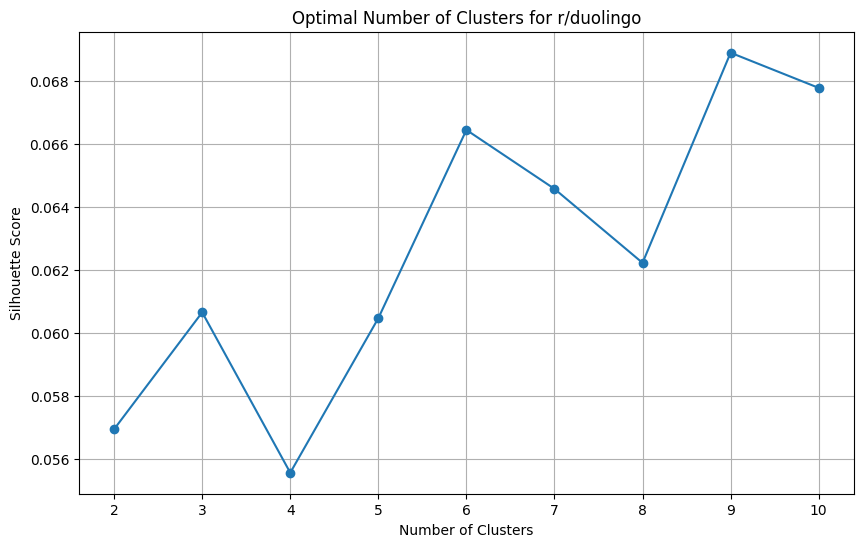

Optimal number of clusters: 9
Cluster sizes: [   1 9783  105  328   63  150   62  127   44]
Cluster 0, 1 : imo, rest, weird, funny, having, isnt, learn, game, future, gain, zone, fucking, gave, gem, gen, gender, general, fun, friend, frustrating
Cluster 1, 9783 : day, language, time, people, learning, app, lesson, course, streak, thing, german, really, make, year, want, yeah, don, learn, use, spanish
Cluster 2, 105 : thank, sense, understand, make, hope, didnt, god, cool, hopefully, explanation, ill, realize, different, get, appreciate, lot, used, try, future, figure
Cluster 3, 328 : word, language, sentence, time, new, english, learning, lesson, use, spanish, learn, grammar, way, german, course, used, really, need, remember, different
Cluster 4, 63 : followed, plushie, enjoy, luck, better, fellow, cute, wow, went, funny, poor, meme, win, hey, portuguese, guy, learner, course, lesson, follower
Cluster 5, 150 : lily, zari, love, lin, junior, bea, vikram, vibe, favorite, died, hell, chil

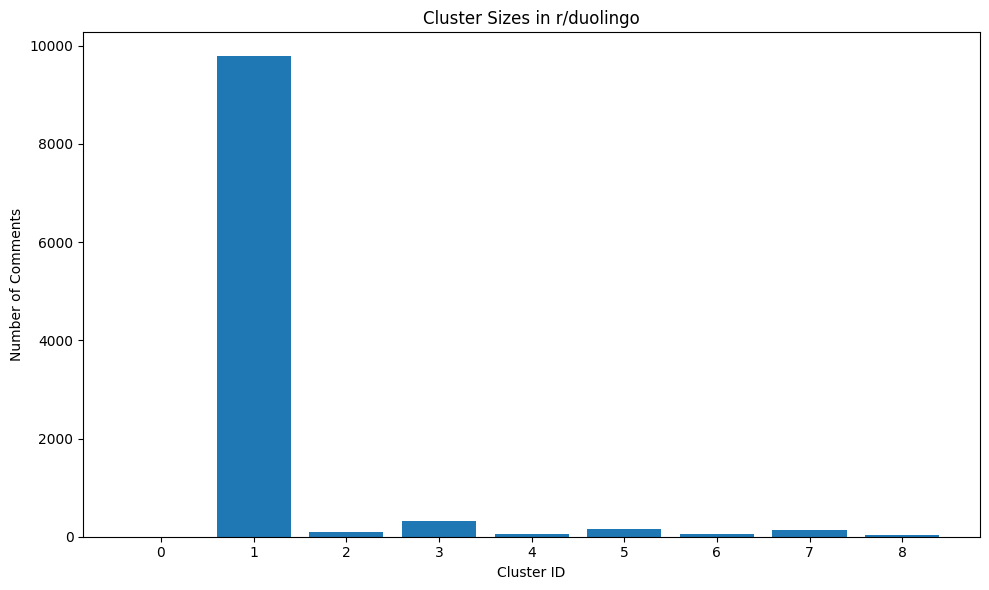



Analyzing clusters in r/duolingomemes


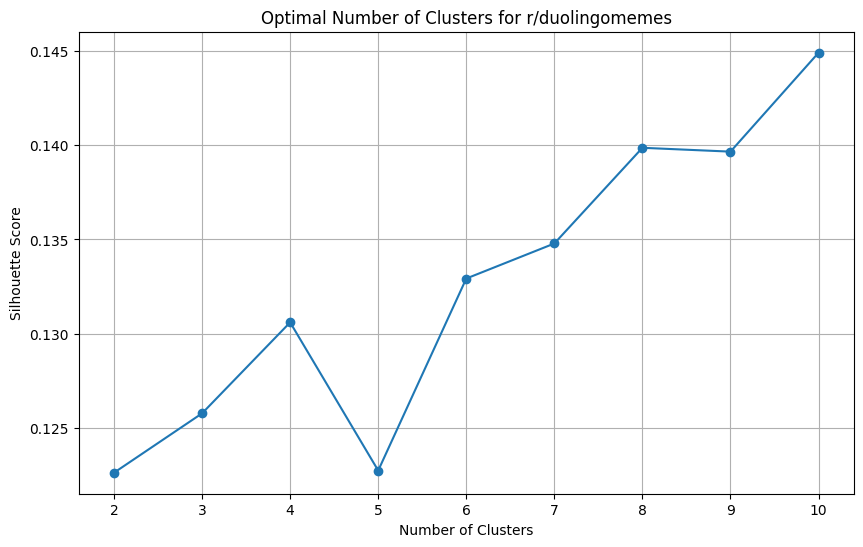

Optimal number of clusters: 10
Cluster sizes: [7477   31    9   44   70   60   67   44   26    9]
Cluster 0, 7477 : day, streak, lesson, guess, mean, language, mmmm, time, year, make, yeah, family, look, don, nice, thing, german, spanish, soap, need
Cluster 1, 31 : guy, year, streak, math, finally, he, scared, maybe, went, feel, bot, family, look, short, currently, damn, meme, holy, saw, chinese
Cluster 2, 9 : open, fbi, chicken, reddit, haven, lingo, inside, lock, pretty, door, bear, hate, soap, fix, flag, friend, fried, french, freeze, free
Cluster 3, 44 : nah, hell, he, question, fried, need, exercise, tbh, fine, work, duo, win, saw, sorry, thanks, right, basement, like, reason, vodka
Cluster 4, 70 : learn, language, spanish, english, new, word, mean, japanese, want, trying, best, german, polish, phrase, idea, way, day, duo, learning, vanish
Cluster 5, 60 : right, youre, lesson, streak, hat, cursed, hell, took, heart, answer, omg, change, hate, sure, tesla, run, lucky, actually, hah

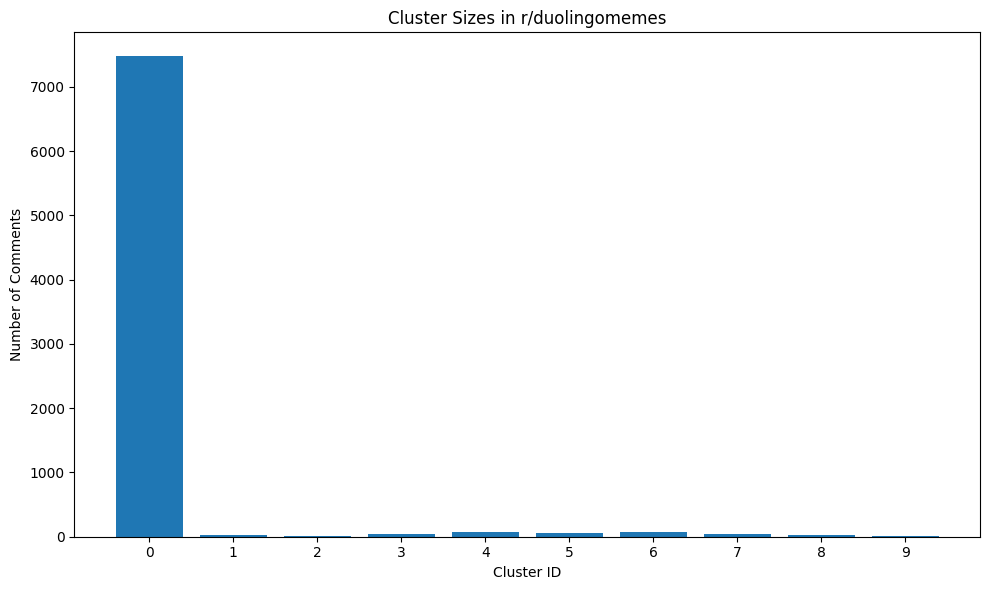



Analyzing clusters in r/shitduolingosays


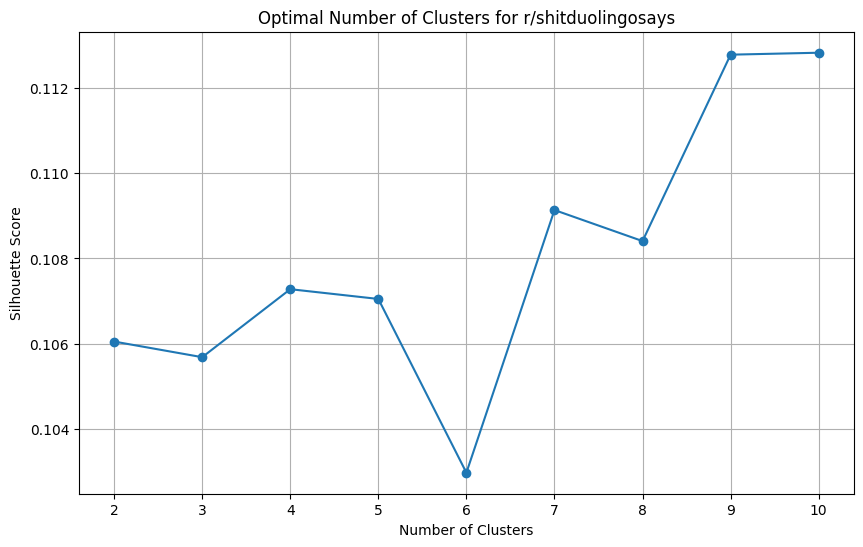

Optimal number of clusters: 10
Cluster sizes: [   9 3852   21   64   36   71   12   12   21   11]
Cluster 0, 9 : confirm, yeah, european, went, kevin, thinking, named, ben, dutch, live, germany, person, drink, coffee, seth, best, said, sentence, bit, water
Cluster 1, 3852 : sentence, mean, maybe, doe, yeah, look, junior, he, cat, thing, german, said, love, way, french, make, right, course, need, day
Cluster 2, 21 : kid, doe, he, poor, said, junior, fun, wrong, probably, saying, little, consider, mom, say, illegal, nah, song, missing, europe, word
Cluster 3, 64 : language, learning, german, mean, second, thought, cool, english, word, course, guess, peru, italian, app, translate, norwegian, romance, learn, spanish, actually
Cluster 4, 36 : ich, auch, bin, ein, mayo, liebe, nicht, dich, nur, für, mir, und, mich, da, ist, auf, sie, falstaff, katze, nein
Cluster 5, 71 : word, german, russian, language, don, spanish, time, compound, cock, english, mean, use, hebrew, radical, teacher, welsh, 

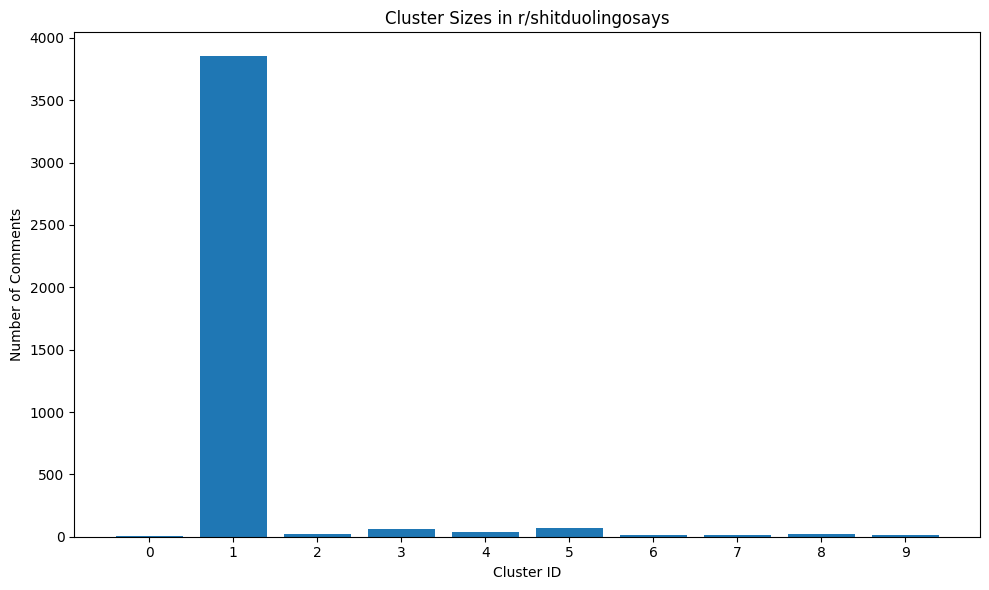


Cluster analysis complete.


In [28]:
# Perform cluster analysis by subreddit using cleaned text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import silhouette_score

def perform_cluster_analysis(subreddit_df, n_terms=20):
    """
    Perform cluster analysis on a dataframe of comments from a subreddit.
    
    Parameters:
    -----------
    subreddit_df : pandas.DataFrame
        DataFrame containing comments from a specific subreddit with 'clean_text' column
    n_terms : int, default=20
        Number of top terms to display per cluster
        
    Returns:
    --------
    dict
        Dictionary containing cluster sizes and top terms for each cluster
    """
    # Minimum number of comments needed for clustering
    min_comments = 15
    
    # Skip if too few comments
    if len(subreddit_df) < min_comments:
        print(f"Not enough comments ({len(subreddit_df)}) for meaningful clustering")
        return None
    
    # Create TF-IDF vectors from cleaned text
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(subreddit_df['clean_text'])
    
    # Skip if matrix is empty
    if tfidf_matrix.shape[1] == 0:
        print("No features extracted from text")
        return None
    
    # Determine optimal number of clusters using silhouette score
    max_clusters = min(10, len(subreddit_df) // 5)  # Cap at 10 or 1/5 of data points
    min_clusters = 2
    
    if max_clusters < min_clusters:
        max_clusters = min_clusters
    
    silhouette_scores = []
    cluster_range = range(min_clusters, max_clusters + 1)
    
    for n_clusters in cluster_range:
        # Apply K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(tfidf_matrix)
        
        # Calculate silhouette score
        if len(np.unique(cluster_labels)) > 1:  # Ensure we have at least 2 clusters
            score = silhouette_score(tfidf_matrix, cluster_labels)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(-1)  # Invalid score
    
    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range, silhouette_scores, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title(f'Optimal Number of Clusters for r/{subreddit_df["subreddit"].iloc[0]}')
    plt.grid(True)
    plt.show()
    
    # Select optimal number of clusters
    if len(silhouette_scores) > 0 and max(silhouette_scores) > 0:
        optimal_n_clusters = cluster_range[np.argmax(silhouette_scores)]
        print(f"Optimal number of clusters: {optimal_n_clusters}")
    else:
        optimal_n_clusters = min_clusters
        print(f"Using default number of clusters: {optimal_n_clusters}")
    
    # Apply K-means with optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
    subreddit_df['cluster'] = kmeans.fit_predict(tfidf_matrix)
    
    # Get cluster sizes
    cluster_sizes = subreddit_df['cluster'].value_counts().sort_index()
    print(f"Cluster sizes: {cluster_sizes.values}")
    
    # Get top terms for each cluster
    feature_names = tfidf_vectorizer.get_feature_names_out()
    cluster_terms = {}
    
    for cluster_id in range(optimal_n_clusters):
        # Get the centroid of the cluster
        centroid = kmeans.cluster_centers_[cluster_id]
        # Get the indices of the top terms
        top_indices = centroid.argsort()[-n_terms:][::-1]
        # Get the terms corresponding to these indices
        top_terms = [feature_names[i] for i in top_indices]
        cluster_terms[cluster_id] = top_terms
        
        print(f"Cluster {cluster_id}, {cluster_sizes.get(cluster_id, 0)} : {', '.join(top_terms)}")
    
    # Plot cluster sizes
    plt.figure(figsize=(10, 6))
    plt.bar(range(optimal_n_clusters), [cluster_sizes.get(i, 0) for i in range(optimal_n_clusters)])
    plt.xlabel('Cluster ID')
    plt.ylabel('Number of Comments')
    plt.title(f'Cluster Sizes in r/{subreddit_df["subreddit"].iloc[0]}')
    plt.xticks(range(optimal_n_clusters))
    plt.tight_layout()
    plt.show()
    
    # Add cluster_id to the original dataframe
    # Get the indices from the subreddit_df
    indices = subreddit_df.index
    # Update the original dataframe with cluster assignments
    df.loc[indices, 'cluster_id'] = subreddit_df['cluster'].values
    
    return {
        'sizes': cluster_sizes.to_dict(),
        'terms': cluster_terms,
        'n_clusters': optimal_n_clusters
    }

print("\n## Cluster Analysis by Subreddit ##")

# Get list of subreddits
subreddits = df['subreddit'].unique()
print(f"Found {len(subreddits)} subreddits for cluster analysis")

# Number of top terms to display per cluster
n_terms = 20

# Initialize cluster_id column in the original dataframe
df['cluster_id'] = -1  # -1 indicates no cluster assigned

# Store results for comparison
cluster_results = {}

for subreddit in subreddits:
    print(f"\n\nAnalyzing clusters in r/{subreddit}")
    
    # Filter data for this subreddit
    subreddit_df = df[df['subreddit'] == subreddit].copy()
    
    # Perform cluster analysis
    results = perform_cluster_analysis(subreddit_df, n_terms)
    
    if results:
        cluster_results[subreddit] = results

print("\nCluster analysis complete.")

In [29]:
# Define the subreddit and cluster to debug
target_subreddit = 'duolingo'
target_cluster = 4


subreddit_cluster_df = df[df['subreddit'] == target_subreddit]
subreddit_cluster_df = subreddit_cluster_df[subreddit_cluster_df['cluster_id'] == target_cluster]

for text in subreddit_cluster_df.sample(min(10, len(subreddit_cluster_df)))['comment_text']:
    print(text)
    print("-" * 50)

I followed you!

![gif](giphy|fsQbx1hX7hPBBpIM5b|downsized)
--------------------------------------------------
I’ve followed ✊😔
--------------------------------------------------
Just followed you on duolingo! :)
--------------------------------------------------
Hey, just followed! Good luck. 🍀🤞
--------------------------------------------------
I just followed you! 
Barniferus!
Chocolate 4eva
--------------------------------------------------
I followed! That Pokemon's soo cute 🥺 
--------------------------------------------------
Followed!
--------------------------------------------------
followed 🌺
--------------------------------------------------
Followed. :)
--------------------------------------------------
Just followed :3
--------------------------------------------------


In [30]:
# Find examples with the word 'lily' in clean_text
lily_examples = df[df['clean_text'].str.contains('lily', case=False, na=False)]

if len(lily_examples) > 0:
    print(f"\nFound {len(lily_examples)} examples containing 'lily':")
    for idx, row in lily_examples.head(10).iterrows():
        print(f"\n--- Example {idx} ---")
        print(f"Subreddit: r/{row['subreddit']}")
        print(f"Text: {row['clean_text'][:300]}...")  # Show first 300 chars
        print("-" * 80)
else:
    print("\nNo examples found containing the word 'lily'.")



Found 242 examples containing 'lily':

--- Example 413 ---
Subreddit: r/duolingo
Text: given clearly lily dog like acute angle...
--------------------------------------------------------------------------------

--- Example 426 ---
Subreddit: r/duolingo
Text: lily dog like temperature unlikely outside hottest desert specific actually mean multiply temperature result yield temperature likely occur inside roche limit sun ignore agree dog lot nicer...
--------------------------------------------------------------------------------

--- Example 440 ---
Subreddit: r/duolingo
Text: original temperature lily dog like alternatively original temperature lily dog like...
--------------------------------------------------------------------------------

--- Example 455 ---
Subreddit: r/duolingo
Text: welp lily antichrist dog hell hound...
--------------------------------------------------------------------------------

--- Example 571 ---
Subreddit: r/duolingo
Text: lily...
----------------------

## Countries analysis

In [33]:
from pycountry import countries
from collections import Counter

# Get all words from comments
all_words = ' '.join(text.lower() for text in df['comment_text'] if isinstance(text, str)).split()

# Count occurrences of each country
country_counts = Counter()
for country in countries:
    country_name = country.name.lower()
    if country_name in all_words:
        count = all_words.count(country_name)
        country_counts[country_name] = count

# Sort countries by count in descending order
sorted_countries = sorted(country_counts.items(), key=lambda x: x[1], reverse=True)

print(f'Number of countries found: {len(sorted_countries)}')
print('\nTop countries by mentions:')
for country, count in sorted_countries:
    print(f'{country}: {count}')
contries = [country for country, count in sorted_countries]

Number of countries found: 42

Top countries by mentions:
germany: 23
japan: 15
france: 14
italy: 14
canada: 11
mexico: 10
china: 8
spain: 8
chile: 5
sweden: 5
antarctica: 4
israel: 4
chad: 4
australia: 3
austria: 3
brazil: 3
switzerland: 3
greece: 3
netherlands: 3
peru: 3
poland: 3
thailand: 3
belgium: 2
bulgaria: 2
cuba: 2
denmark: 2
egypt: 2
finland: 2
india: 2
ireland: 2
romania: 2
slovakia: 2
argentina: 1
belarus: 1
colombia: 1
georgia: 1
hungary: 1
nepal: 1
pakistan: 1
portugal: 1
tajikistan: 1
samoa: 1


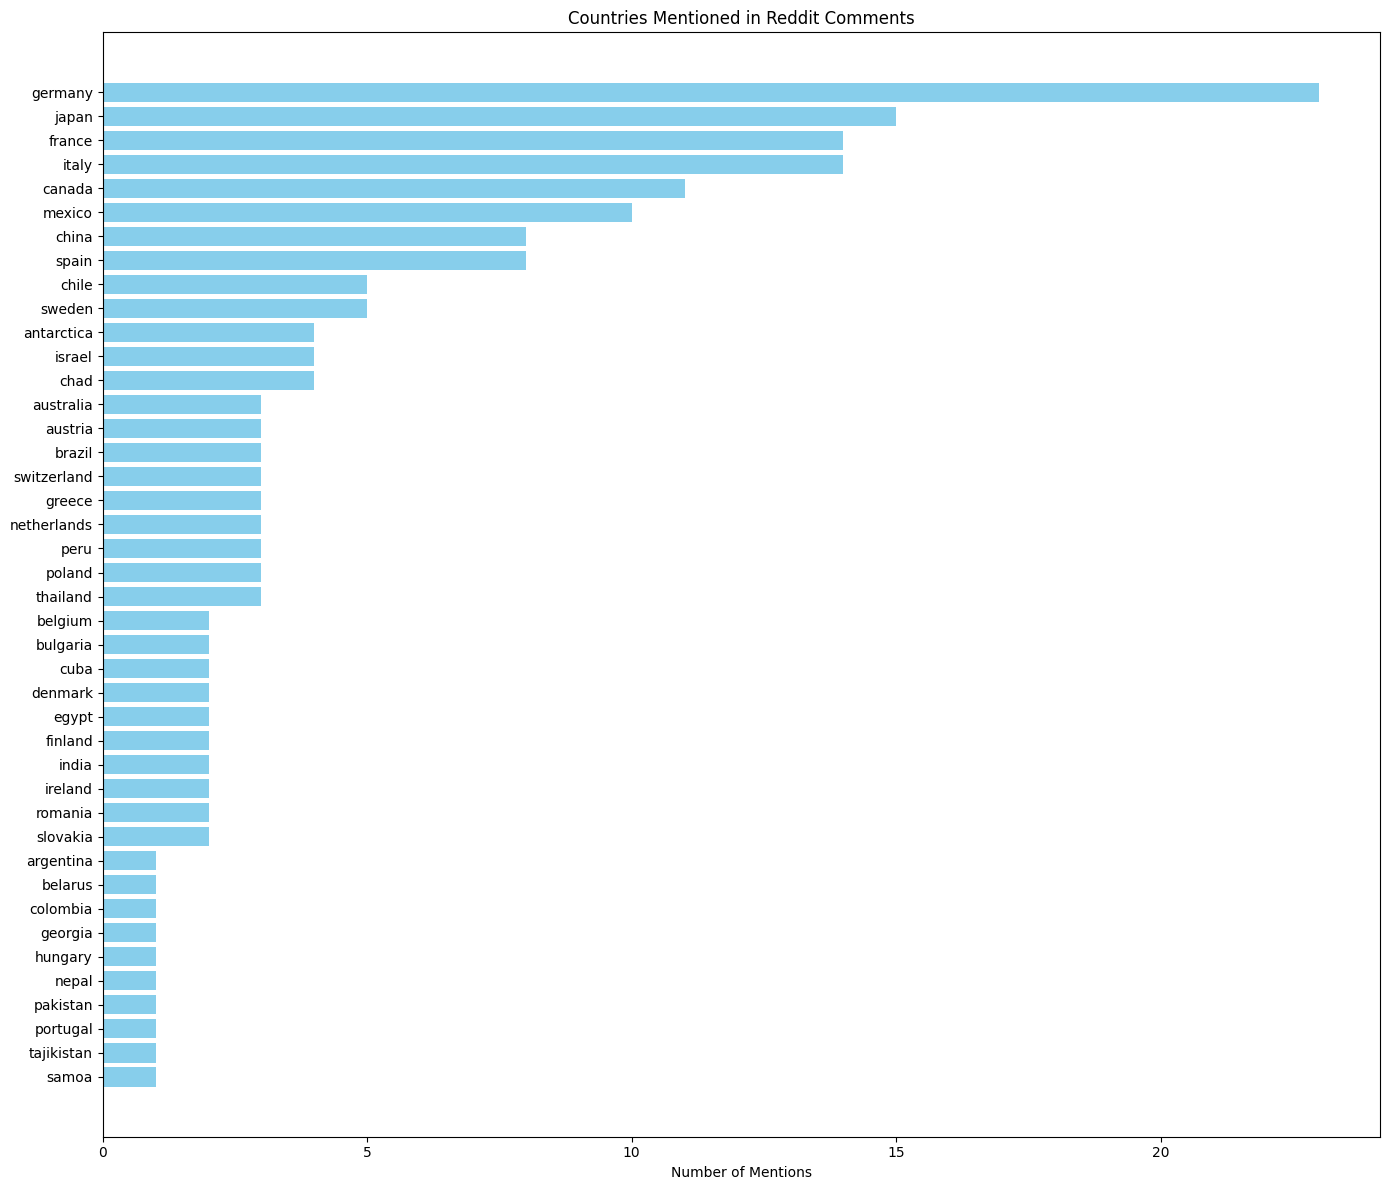

Total countries mentioned: 42
Most mentioned country: germany with 23 mentions
Total mentions across all countries: 182


In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Extract countries and counts for plotting
countries = [country for country, count in sorted_countries]
counts = [count for country, count in sorted_countries]

# Create a horizontal bar chart
plt.figure(figsize=(14, 12))
y_pos = np.arange(len(countries))
plt.barh(y_pos, counts, align='center', color='skyblue')
plt.yticks(y_pos, countries)
plt.xlabel('Number of Mentions')
plt.title('Countries Mentioned in Reddit Comments')
plt.gca().invert_yaxis()  # Invert y-axis to show highest counts at the top
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Total countries mentioned: {len(sorted_countries)}")
print(f"Most mentioned country: {sorted_countries[0][0]} with {sorted_countries[0][1]} mentions")
print(f"Total mentions across all countries: {sum(counts)}")



## Junk

In [31]:
from pathlib import Path

jup_path = Path("reddit_comment_analysis.ipynb")

import json

jup = json.loads(jup_path.read_text())

for cell in jup["cells"]:
    if 'outputs' in cell:
        print(f'len: {len(cell["outputs"])}')
        del cell["outputs"]

new_jup_path = Path("reddit_comment_analysis_obfuscated.ipynb")

new_jup_path.write_text(json.dumps(jup))


len: 1
len: 1
len: 0
len: 2
len: 2
len: 1
len: 1
len: 0
len: 0
len: 2
len: 2
len: 2
len: 1
len: 2
len: 2
len: 8
len: 0
len: 1
len: 1
len: 7
len: 17
len: 17
len: 17
len: 1
len: 1
len: 9
len: 1
len: 1
len: 0
len: 2


48764